# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Write Intro


Metric: 10-day profit

Profit margin 25%:
https://www.visualcapitalist.com/the-economics-of-coffee-in-one-chart/

Starbucks operating margin Americas 20% (2019):
https://investor.starbucks.com/financial-data/annual-reports/default.aspx

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import progressbar
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
sns.set_context('talk')
%matplotlib inline
palette = sns.color_palette()

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
for channel in ['web', 'email', 'mobile', 'social']:
    output_name = "channel_" + channel
    portfolio.loc[:,output_name] = \
        portfolio.loc[:, 'channels'].map(lambda x: channel in x)
portfolio.drop(columns='channels', inplace=True)
portfolio

,reward,difficulty,duration,offer_type,id,channel_web,channel_email,channel_mobile,channel_social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,False,True,True,True
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,True,True,True,True
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,True,True,True,False
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,True,False
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,True,False,False
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,True,True,True,True
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,True,True,True,True
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,False,True,True,True
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,True,True,True,True
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,True,True,True,False


In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [6]:
# Convert became_member_on to datetime and tranform into to days_of_membership (more model-friendly)
profile['became_member_on'] = pd.to_datetime(profile.became_member_on, format="%Y%m%d")
profile['days_of_membership'] = (pd.to_datetime(profile.became_member_on.max()) - profile.became_member_on).dt.days

In [7]:
print("Number of profiles with gender = NaN:", profile.gender.isna().sum())
print("Number of profiles with income = NaN:", profile.income.isna().sum())
print("Number of profiles with income and gender = NaN:", 
      profile[(profile.gender.isna()) & (profile.income.isna())].shape[0])
print("Number of profiles with age = NaN:", profile.age.isna().sum())
print("Ages of profiles with gender = NaN:", profile[profile.gender.isna()]['age'].unique())
print()
print("Newest member join date:", profile.became_member_on.max())
print("Oldest member join date:", profile.became_member_on.min())

Number of profiles with gender = NaN: 2175
Number of profiles with income = NaN: 2175
Number of profiles with income and gender = NaN: 2175
Number of profiles with age = NaN: 0
Ages of profiles with gender = NaN: [118]

Newest member join date: 2018-07-26 00:00:00
Oldest member join date: 2013-07-29 00:00:00


In [8]:
# It seems that a certain percentage of profiles are simply anonymous - all we have is a join date
# This can also be useful information, so capture it in another column
profile['anonymous'] = profile.gender.isna()

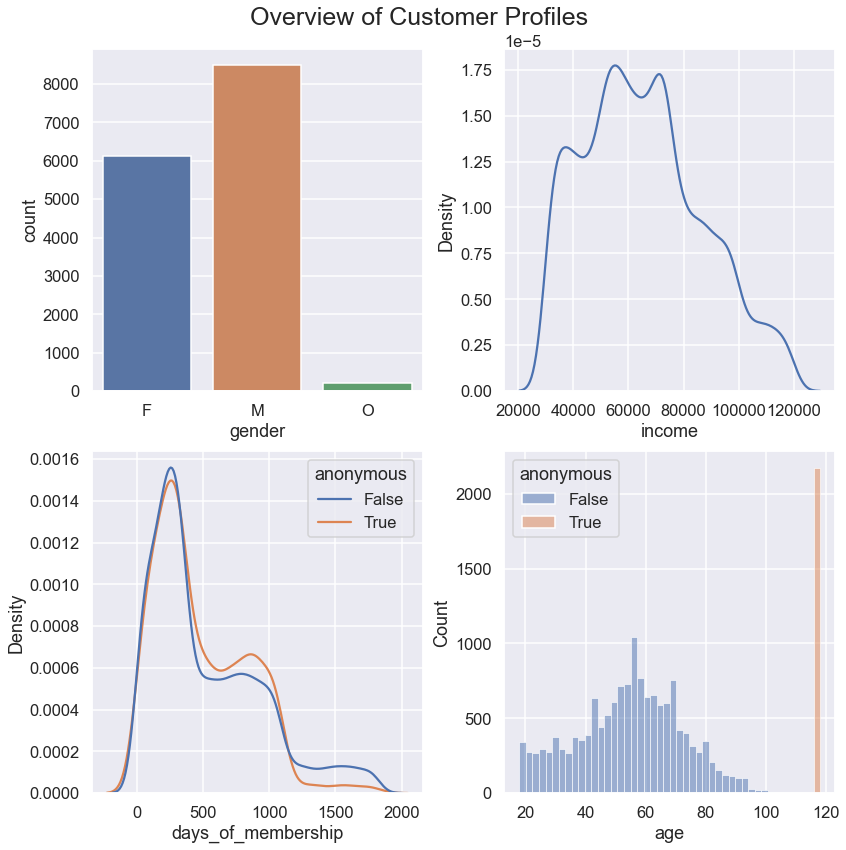

In [9]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
axs=axs.flatten()
sns.countplot(data=profile, x='gender', ax=axs[0])
sns.kdeplot(data=profile, x='income', ax=axs[1])
sns.kdeplot(data=profile, x='days_of_membership', hue='anonymous', ax=axs[2], common_norm=False)
sns.histplot(data=profile, x='age', hue='anonymous', ax=axs[3])
f.suptitle('Overview of Customer Profiles', fontsize=25)
plt.tight_layout();

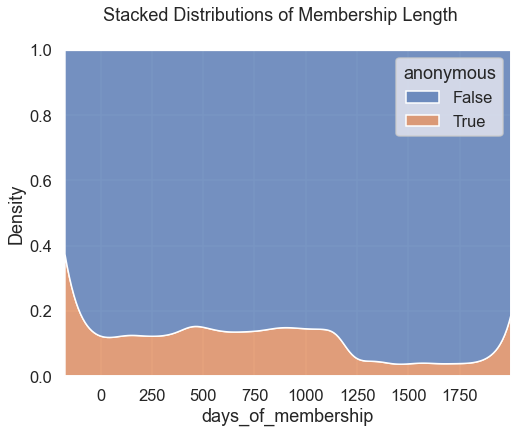

In [10]:
f, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(data=profile, x='days_of_membership', hue='anonymous', multiple='fill');
f.suptitle('Stacked Distributions of Membership Length', fontsize=18);

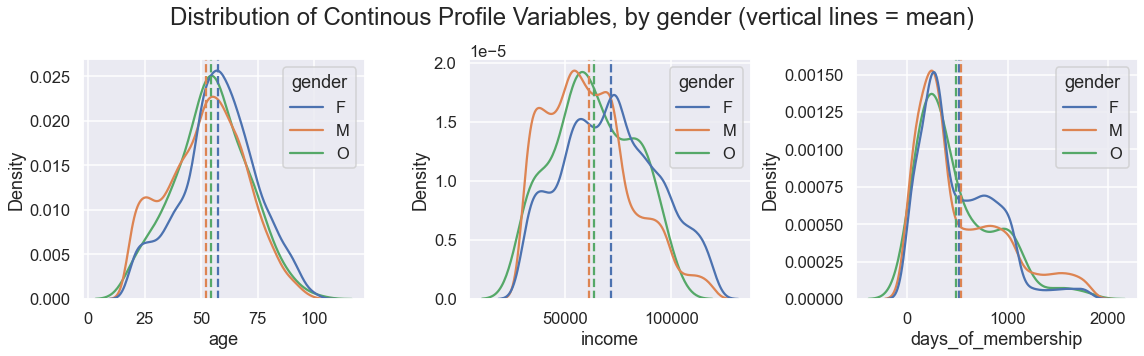

In [11]:
f, axs = plt.subplots(ncols=3, figsize=(16,5))
axs = axs.flatten()

sns.kdeplot(data=profile, x='age', hue='gender', common_norm=False, ax=axs[0])
sns.kdeplot(data=profile, x='income', hue='gender', common_norm=False, ax=axs[1])
sns.kdeplot(data=profile, x='days_of_membership', hue='gender', common_norm=False, ax=axs[2])
f.suptitle('Distribution of Continous Profile Variables, by gender (vertical lines = mean)', fontsize=24)
for i, facet in enumerate(['age', 'income', 'days_of_membership']):
    for j, k in enumerate(profile.groupby('gender')[facet].mean()):
        axs[i].axvline(k, color=palette[j], ls='--')
plt.tight_layout();

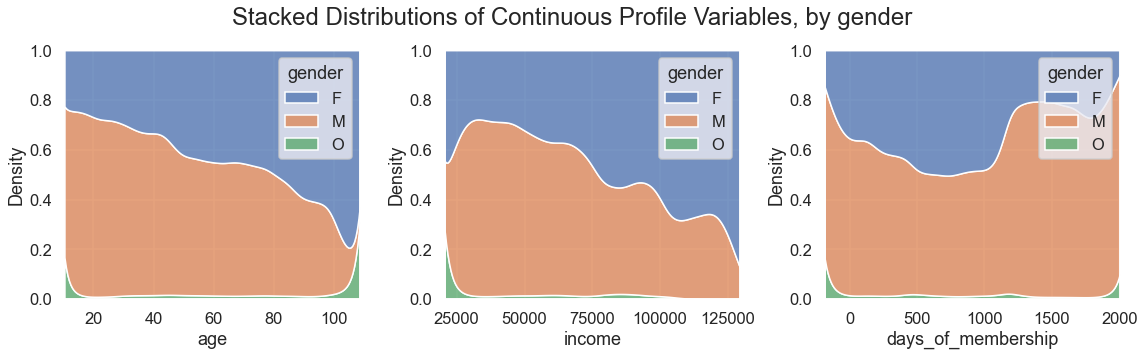

In [12]:
f, axs = plt.subplots(ncols=3, figsize=(16,5))
axs = axs.flatten()

sns.kdeplot(data=profile, x='age', hue='gender', multiple='fill', ax=axs[0])
sns.kdeplot(data=profile, x='income', hue='gender', multiple='fill', ax=axs[1])
sns.kdeplot(data=profile, x='days_of_membership', hue='gender', multiple='fill', ax=axs[2])
f.suptitle('Stacked Distributions of Continuous Profile Variables, by gender', fontsize=24)
plt.tight_layout()

In [13]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [14]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [15]:
# Examine structure of transcript dataframe
random_person = transcript.person.iloc[600]
transcript[transcript.person == random_person]

,person,event,value,time
600,99297ea01107436fa8c2e2bc86f55d89,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
12783,99297ea01107436fa8c2e2bc86f55d89,transaction,{'amount': 5.78},0
12784,99297ea01107436fa8c2e2bc86f55d89,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
44385,99297ea01107436fa8c2e2bc86f55d89,transaction,{'amount': 6.07},114
109946,99297ea01107436fa8c2e2bc86f55d89,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},330
111426,99297ea01107436fa8c2e2bc86f55d89,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},336
139657,99297ea01107436fa8c2e2bc86f55d89,transaction,{'amount': 8.97},372
139658,99297ea01107436fa8c2e2bc86f55d89,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,372
151215,99297ea01107436fa8c2e2bc86f55d89,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},408
180062,99297ea01107436fa8c2e2bc86f55d89,transaction,{'amount': 12.73},438


In [16]:
# Extract the offer ID and transaction value from the respective rows
def get_offer_id(value_col):
    """
    Function indended to be applied to the transcript.value column via Series.apply
    to extract the offer ID,
    
    Parameters:
    value_col: (dict) a value from the pandas series transcript.value
    
    returns: (string) offer_id if the row contains an offer, np.NaN if not
    """
    
    # Some of the rows store offer id as 'offer id' with a space
    if 'offer id' in value_col.keys():
        offer_id = value_col['offer id']
    # Other rows store it with an underscore
    elif 'offer_id' in value_col.keys():
        offer_id = value_col['offer_id']
    # Some rows are transactions and do not refer to an offer
    else:
        offer_id = np.NaN
    
    return offer_id


def get_amount(value_col):
    """
    Function intended to be applied to the transcript.value column via Series.apply
    to extract the transaction amount
    Parameters:
    value_col: (dict) a value from the pandas series transcript.value
    
    returns: (string) the amount if the row contains transaction, np.NaN if not
    """
    
    if 'amount' in value_col.keys():
        amount = value_col['amount']
    else:
        amount = np.NaN
    
    return amount

transcript['offer_id'] = transcript.value.apply(get_offer_id)
transcript['amount'] = transcript.value.apply(get_amount)

In [17]:
print("Times offers were sent (hours):", transcript[transcript.event=='offer received'].time.unique())
print("Times offers were sent (days):", transcript[transcript.event=='offer received'].time.unique() / 24)
print("Total test length (hours):", transcript.time.max())
print("Total test length (days):", transcript.time.max()/24)

Times offers were sent (hours): [  0 168 336 408 504 576]
Times offers were sent (days): [ 0.  7. 14. 17. 21. 24.]
Total test length (hours): 714
Total test length (days): 29.75


In [18]:
offer_repeat_count = (transcript[transcript.event == 'offer received']
     .groupby(['person','offer_id','time'])
     .size().reset_index().drop(columns=0).groupby(by=['person', 'offer_id'])['time'].nunique())
print("Maximum number of times the same user received the same offer:", offer_repeat_count.max())
print("\nNumber of times the same user-offer combination repeated:")
offer_repeat_count.value_counts()

Maximum number of times the same user received the same offer: 5

Number of times the same user-offer combination repeated:


1    51570
2    10523
3     1124
4       66
5        5
Name: time, dtype: int64

## Processing the Transcript Data

To aid in the analysis of which users respond to which offers, a dataframe is needed which relates users to each individual offer event, along with information such as whether the offer was viewed and completed.  An example of such a structure would be:

|    | person                           | offer_id                         |   time_received | viewed   |   time_viewed | completed   |   time_completed |
|---:|:---------------------------------|:---------------------------------|----------------:|:---------|--------------:|:------------|-----------------:|
|  0 | 78afa995795e4d85b5d9ceeca43f5fef | 9b98b8c7a33c4b65b9aebfe6a799e6d9 |               0 | True     |             6 | True        |              132 |
|  1 | 78afa995795e4d85b5d9ceeca43f5fef | 5a8bc65990b245e5a138643cd4eb9837 |             168 | True     |           216 | False       |              nan |
|  2 | 78afa995795e4d85b5d9ceeca43f5fef | ae264e3637204a6fb9bb56bc8210ddfd |             408 | True     |           408 | True        |              510 |
|  3 | 78afa995795e4d85b5d9ceeca43f5fef | f19421c1d4aa40978ebb69ca19b0e20d |             504 | True     |           582 | True        |              510 |
|  4 | a03223e636434f42ac4c3df47e8bac43 | 0b1e1539f2cc45b7b9fa7c272da2e1d7 |               0 | True     |             6 | False       |              nan |
|  ... | ... | ... |               ... | ...     |             ... | ...       |              ... |

This is rendered _extremely_ complex by the lack of a unique identifier for each offer presentation event (offer presentation meaning a unique combination of user, offer, and time sent).  Since each offer can be sent multiple times, the transcript data cannot simply be grouped by person and offer and transformed in different ways to determine whether each specific offer has been viewed.  The duplication of offers causes these group-summarize-merge operations to be ambiguous - the grouping must be by person, offer, _and_ time sent.  Since time sent is not included with each view and completion event, this is not possible via groupby opereations.  Instead, the data must be processed line-by-line in order.  

There are a number of places where this problem also renders the data ambiguous.

### Offer Completion Ambiguity
During the test, offers were sent every 7 days.  Some offers have a duration of 10 days, and these longer offers can be sent back-to-back.  So a user can have 2 copies of the same offer active at the same time.  Consider the scenarios below:

![](Back_to_back_illustration.png)

Scenarios 1, 2 and 3 are entirely ambiguous.  The offer completion could be considered applied to either of the two active offers.  It's possible that the future behavior could disambiguate the situation, as in scenario 4.  There the user later completes the second offer, allowing a firm conclusion that the first completion applied to the first offer.  But it's also possible that a third copy of the same offer could come in and complicate the situation again, as in scenario 5.  It's ambiguous, and a consistent logic has to be applied.

**To handle this scenario, any offer completion will be applied to the _oldest unexpired uncompleted_ offer of the same type.** This is consistent and makes sense for real-life app usage and offers.  Clearly the user would want the opportunity to complete the second offer, and as the offer was sent twice the marketing department would probably also like the user to have the opportunity to complete the second offer.

### Offer Viewing Ambiguity
Determining which duplicate of an offer a user has viewed is complicated further by the fact that an offer can be viewed after it has expired.  Consider the case of our good friend `d56cb6d6b61648fc9525678a207c38f1` (Deefty for short).  Deefty receives offer `9b98b8c7a33c4b65b9aebfe6a799e6d9` twice, which is a 7-day BOGO offer.

|    |   reward | channels                             |   difficulty |   duration | offer_type    | id                               |
|---:|---------:|:-------------------------------------|-------------:|-----------:|:--------------|:---------------------------------|
|  0 |       10 | ['email', 'mobile', 'social']        |           10 |          7 | bogo          | ae264e3637204a6fb9bb56bc8210ddfd |
|  1 |       10 | ['web', 'email', 'mobile', 'social'] |           10 |          5 | bogo          | 4d5c57ea9a6940dd891ad53e9dbe8da0 |
|  2 |        0 | ['web', 'email', 'mobile']           |            0 |          4 | informational | 3f207df678b143eea3cee63160fa8bed |
|**3**|    **5** | **['web', 'email', 'mobile']**       |        **5** |      **7** | **bogo**      | **9b98b8c7a33c4b65b9aebfe6a799e6d9** |
|  4 |        5 | ['web', 'email']                     |           20 |         10 | discount      | 0b1e1539f2cc45b7b9fa7c272da2e1d7 |

In Deefty's transcript, they receive the offer twice with a gap in between, then view one of the offers.

|        | person                           | event          | value                                            |   time |
|-------:|:---------------------------------|:---------------|:-------------------------------------------------|-------:|
|   8736 | d56cb6d6b61648fc9525678a207c38f1 | offer received | {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'} |      0 |
|  17323 | d56cb6d6b61648fc9525678a207c38f1 | offer viewed   | {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'} |      6 |
|  17324 | d56cb6d6b61648fc9525678a207c38f1 | transaction    | {'amount': 0.35000000000000003}                  |      6 |
|  37810 | d56cb6d6b61648fc9525678a207c38f1 | transaction    | {'amount': 7.46}                                 |     78 |
|  39124 | d56cb6d6b61648fc9525678a207c38f1 | transaction    | {'amount': 1.58}                                 |     84 |
|**61923**|**d56cb6d6b61648fc9525678a207c38f1**|**offer received**|**{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}**| **168** |
| 119567 | d56cb6d6b61648fc9525678a207c38f1 | offer received | {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'} |    336 |
| 126056 | d56cb6d6b61648fc9525678a207c38f1 | offer viewed   | {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'} |    336 |
| 159376 | d56cb6d6b61648fc9525678a207c38f1 | offer received | {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'} |    408 |
| 170117 | d56cb6d6b61648fc9525678a207c38f1 | offer viewed   | {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'} |    414 |
| 170118 | d56cb6d6b61648fc9525678a207c38f1 | transaction    | {'amount': 1.6099999999999999}                   |    414 |
|**210312**|**d56cb6d6b61648fc9525678a207c38f1**|**offer received**|**{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}**|  **504**|
| 289170 | d56cb6d6b61648fc9525678a207c38f1 | transaction    | {'amount': 2.85}                                 |    642 |
|**305072**|**d56cb6d6b61648fc9525678a207c38f1**|**offer viewed** |**{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}**|  **708**|

The expiry time of the second offer is `504 + 7 * 24 = 672`, meaning that both of the offers are expired when Deefty views one of the two offers at `time=708`.  Intuition might apply LIFO logic and say he viewed the most recent one - but given that offers can be viewed after expiry FIFO logic could also be applied (as it was in the offer completion).  Again, the situation is ambiguous and a consistent logic must be applied.  The stakes are slightly higher here, since a user may later complete the offer.  If the view was applied to the wrong version of the offer, this could erroneously show that the user completed the offer without viewing it.

**To handle ambiguous view data, offer views will be applied:**
1. To the _oldest unexpired unviewed_ offer
-- if there are no active unviewed offers --  

2. To the _oldest expired unviewed_ offer

### Recommendation
These types of ambiguities can have a significant impact on the results.  To improve the data integrity, the data enginers / app developers should be requested to:
1. Establish an ID which uniquely identifies each offer presentation (offer presentation meaning a unique comination of person / offer / time_received)
2. Reference offer views and offer completions to the appropriate offer presentation ID

Depending on the workings of the systems, it is possible that there is a consistent logic which is applied in these ambiguous situations.  In a business situation (where conversations with the app development and loyalty program teams are possible) there is also the possiblity of mapping out the logic flow applied by the real systems in these ambiguous situations and then duplicating that logic in the data processing.  However, the unique ID route is preferred for performance reasons (querying the dataset is faster than iterating through it line by line) and because future system changes could alter the logic flow and compromise data integity again.

In [19]:
# initialize results
offers_dict = {'person': [], 'offer_id': [], 'time_received': [],
              'viewed': [], 'time_viewed': [], 'completed': [], 'time_completed': []}

# iterate through people in the transcripts dataframe
for person in progressbar.progressbar(transcript.person.unique()):
    # pull this person's transcript and sort it by time
    person_transcript = transcript[transcript.person == person].copy().sort_index()
    # set up a dict of offers received by this person
    offers_tmp = {}
    # iterate through entries in the transcript
    for _, tmp in person_transcript.iterrows():
        # entry == offer received
        if tmp.event == 'offer received':
            # add to list of offers
            base_dict = {'viewed': False, 'time_viewed': np.NaN, 
                                    'completed': False, 'time_completed': np.NaN}
            # Need separate cases here:
            #  - Establish the dictionary if this is the first instance of the offer
            #  - Not overwrite the dictionary if this offer has already been given to this user
            if tmp.offer_id in offers_tmp.keys():
                offers_tmp[tmp.offer_id][tmp.time] = base_dict
            else:
                offers_tmp[tmp.offer_id] = {tmp.time: base_dict}
            
            # calculate expiry time and add to dict
            duration_h = portfolio[portfolio.id == tmp.offer_id].reset_index().duration[0] * 24
            offers_tmp[tmp.offer_id][tmp.time]['expiry_time'] = tmp.time + duration_h
            
        # entry == offer viewed
        if tmp.event == 'offer viewed':
            # go through all times this offer has been sent
            view_applied = False
            for previous_time in sorted(list(offers_tmp[tmp.offer_id].keys())):
                # if this iteration of the offer has not expired and has not been viewed
                if (offers_tmp[tmp.offer_id][previous_time]['expiry_time'] >= tmp.time and not 
                    offers_tmp[tmp.offer_id][previous_time]['viewed']):
                    # set viewed to true, set viewed time to now and break out of this loop
                    offers_tmp[tmp.offer_id][previous_time]['viewed'] = True
                    offers_tmp[tmp.offer_id][previous_time]['time_viewed'] = tmp.time
                    view_applied = True
                    break
            
            # if an unexpired unviewed offer was not found
            if not view_applied:
                # iterate back through the list of times this offer has been sent
                for previous_time in sorted(list(offers_tmp[tmp.offer_id].keys())):
                    # this time ignore expiry, only look for unviewed versions
                    if not offers_tmp[tmp.offer_id][previous_time]['viewed']:
                        # when the oldest unviewed offer is found, set variables and break out
                        offers_tmp[tmp.offer_id][previous_time]['viewed'] = True
                        offers_tmp[tmp.offer_id][previous_time]['time_viewed'] = tmp.time
                        break
        # entry == offer completed
        if tmp.event == 'offer completed':
            # go through all the times this offer has been sent
            for previous_time in sorted(list(offers_tmp[tmp.offer_id].keys())):
                # if this iteration of the offer has not expired and has not been completed
                if (offers_tmp[tmp.offer_id][previous_time]['expiry_time'] >= tmp.time and not 
                    offers_tmp[tmp.offer_id][previous_time]['completed']):
                    # set completed to true, set viewed time to now and break out of this loop
                    offers_tmp[tmp.offer_id][previous_time]['completed'] = True
                    offers_tmp[tmp.offer_id][previous_time]['time_completed'] = tmp.time
                    break
    
    # unroll this person's offers into the results dict
    for offer in offers_tmp.keys():
        for time_received in offers_tmp[offer].keys():
            offers_dict['person'].append(person)
            offers_dict['offer_id'].append(offer)
            offers_dict['time_received'].append(time_received)
            offers_dict['viewed'].append(offers_tmp[offer][time_received]['viewed'])
            offers_dict['time_viewed'].append(offers_tmp[offer][time_received]['time_viewed'])
            offers_dict['completed'].append(offers_tmp[offer][time_received]['completed'])
            offers_dict['time_completed'].append(offers_tmp[offer][time_received]['time_completed'])

100% (17000 of 17000) |##################| Elapsed Time: 0:07:19 Time:  0:07:19


In [20]:
offers_df = pd.DataFrame.from_dict(offers_dict)
offers_df.head()

,person,offer_id,time_received,viewed,time_viewed,completed,time_completed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,True,6.0,True,132.0
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,168,True,216.0,False,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408,True,408.0,True,510.0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,True,582.0,True,510.0
4,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,True,6.0,False,NaN


In [21]:
# Do some checks to confirm the processing was done properly

# Confirm correct number of total offers
assert(offers_df.shape[0] == transcript[transcript.event=='offer received'].shape[0])
# Confirm correct number of total views
assert(offers_df.viewed.sum() == transcript[transcript.event=='offer viewed'].shape[0])
# Confirm correct number of total completions
assert(offers_df.completed.sum() == transcript[transcript.event=='offer completed'].shape[0])

# Confirm the same 3 things for 5 random users
for user in np.random.default_rng().choice(profile.id, 5):
    user_transcript = transcript[transcript.person==user]
    assert(offers_df[offers_df.person==user].shape[0] == 
           user_transcript[user_transcript.event=='offer received'].shape[0])
    assert(offers_df[offers_df.person==user].viewed.sum() == 
           user_transcript[user_transcript.event=='offer viewed'].shape[0])
    assert(offers_df[offers_df.person==user].completed.sum() == 
           user_transcript[user_transcript.event=='offer completed'].shape[0])

# Combining the Transcript and Profile datasets (breakdown by user)

In [22]:
# Come back to the portfolio dataframe to understand the test and the customer base a bit better
# Extract total transactions and total transaction value from transcript
transactions_info = transcript[transcript.event=='transaction'].groupby('person').agg(
                                        n_transactions=pd.NamedAgg(column='person', aggfunc=len), 
                                        total_amount=pd.NamedAgg(column='amount', aggfunc=sum))

# Extract data about offer sending, viewing and completion from the offers dataframe

# Summarize offer info by person
offers_sent = (offers_df.groupby(by=['person', 'offer_id'])['time_received'].nunique()
               .rename('times_received').reset_index()
               .groupby('person')['times_received'].sum().rename('n_offers'))
offers_viewed = offers_df.groupby(by='person').viewed.sum().rename('n_offers_viewed')
offers_completed = offers_df.groupby(by='person').completed.sum().rename('n_offers_completed')

# Calculate number of times offers were completed without being viewed and summarize by person
offers_df['completed_not_viewed'] = (offers_df.completed) & ~(offers_df.viewed)
offers_completed_not_viewed = (offers_df.groupby(by='person')
                               .completed_not_viewed
                               .sum()
                               .rename('n_offers_completed_not_viewed'))

In [23]:
# Extend the profile dataset in a separate dataframe for this exploratory analysis
profile_extended = profile.copy()

# Merge in the generated datasets
for extension in [transactions_info, offers_sent, offers_viewed, offers_completed, offers_completed_not_viewed]:
    profile_extended = pd.merge(profile_extended, extension, left_on='id', right_index=True, how='left')

# Any NaNs in this new data indicate that the person had zero (zero transactions, zero offers viewed, etc)
# Need to populate this in the dataframe
for column in ['n_transactions', 'total_amount', 'n_offers',
                         'n_offers_viewed', 'n_offers_completed', 'n_offers_completed_not_viewed']:
    profile_extended[column] = profile_extended[column].fillna(0)

# NaNs occur in this calculation because of div0 errors from six users who got no offers
# Fill those with 0
profile_extended['frac_viewed'] = (profile_extended.n_offers_viewed / profile_extended.n_offers).fillna(0)
profile_extended['frac_completed'] = (profile_extended.n_offers_completed / profile_extended.n_offers).fillna(0)
profile_extended['frac_completed_unviewed'] = \
                    (profile_extended.n_offers_completed_not_viewed / profile_extended.n_offers).fillna(0)
profile_extended.head()

,gender,age,id,became_member_on,income,days_of_membership,anonymous,n_transactions,total_amount,n_offers,n_offers_viewed,n_offers_completed,n_offers_completed_not_viewed,frac_viewed,frac_completed,frac_completed_unviewed
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,529,True,9.0,20.40,5.0,5.0,2.0,0.0,1.0,0.40,0.0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376,False,3.0,77.01,2.0,0.0,1.0,1.0,0.0,0.50,0.5
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,14,True,6.0,14.30,2.0,2.0,0.0,0.0,1.0,0.00,0.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443,False,7.0,159.27,4.0,4.0,3.0,0.0,1.0,0.75,0.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,356,True,3.0,4.65,5.0,3.0,0.0,0.0,0.6,0.00,0.0


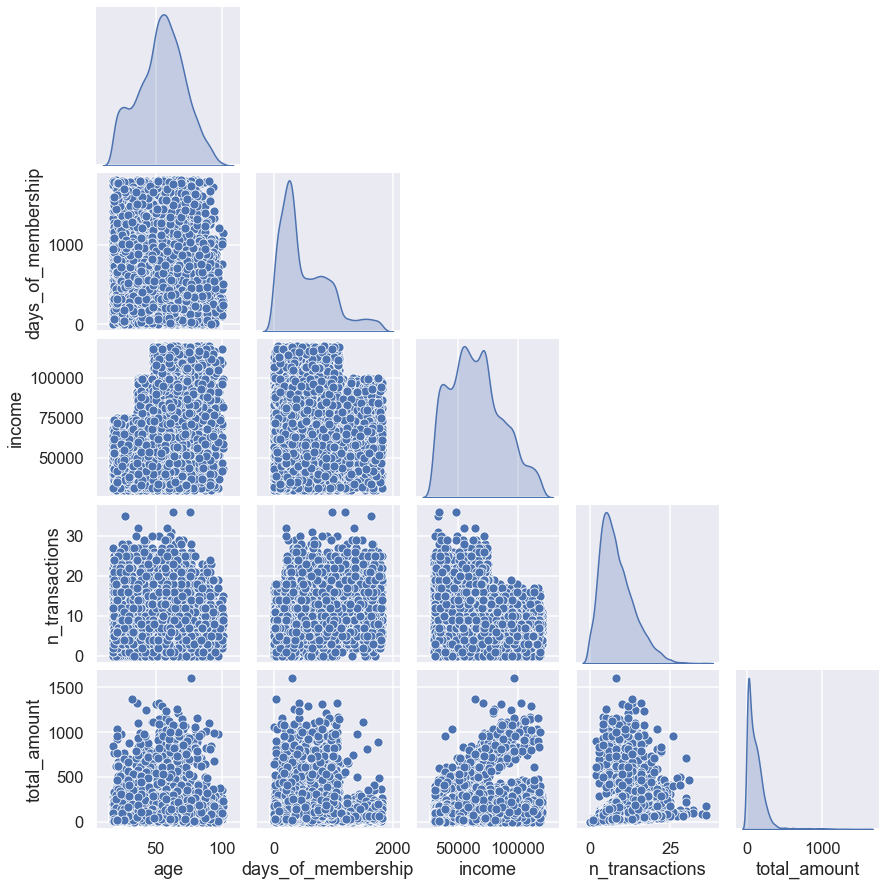

In [24]:
# Examine pairwise relationships in the extended data -- hard to see much
# A minor trend in income vs total amount (possibly with two groups in it), and a bottom limit trend
# in n_transactions vs total amount
# There are also a number of unnatural-looking "corner edges" in the dataset, likely due to the setup
# of the simulation and the subgroups of users who were defined in it. (ex: income vs age)
sns.pairplot(profile_extended[~profile_extended.anonymous].loc[:,
                                  ['gender','age','days_of_membership','income', 'n_transactions', 'total_amount']]
             , corner=True, diag_kind='kde');

In [25]:
## Define plotting routine as a function to reduce repetition
def plot_transcript_vs_categorical(data, category, title="", all_legend=True, hue_order=None):
    """
    Function to plot a seaborn ecdfplot of transaction data, split by a specific categorical variable.
    
    INPUT:
    data: (dataframe) the dataframe to plot
    category: (string) the category to separate by color
    title: (string) the title to put above the plot
    all_legend: (boolean) whether to put legends on all plots.  if false, place only on the last one
    hue_order: (list-like) passed to sns.ecdfplot to control order of the categorical levels
    
    RETURNS:
    none - outputs a a group of plots to the console
    """
    f, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,10))
    axs = axs.flatten()
    
    if all_legend:
        legends = lambda i, axs: True if i>0 else True
    else:
        legends = lambda i, axs: True if i+1==len(axs) else False
    
    for i, column in enumerate(['n_transactions', 'total_amount', 'n_offers',
                         'frac_viewed', 'frac_completed', 'frac_completed_unviewed']):
        sns.ecdfplot(data=data, x=column, hue=category, ax=axs[i], legend=legends(i, axs), hue_order=hue_order)
    
    f.suptitle(title, fontsize=24)
    plt.tight_layout()

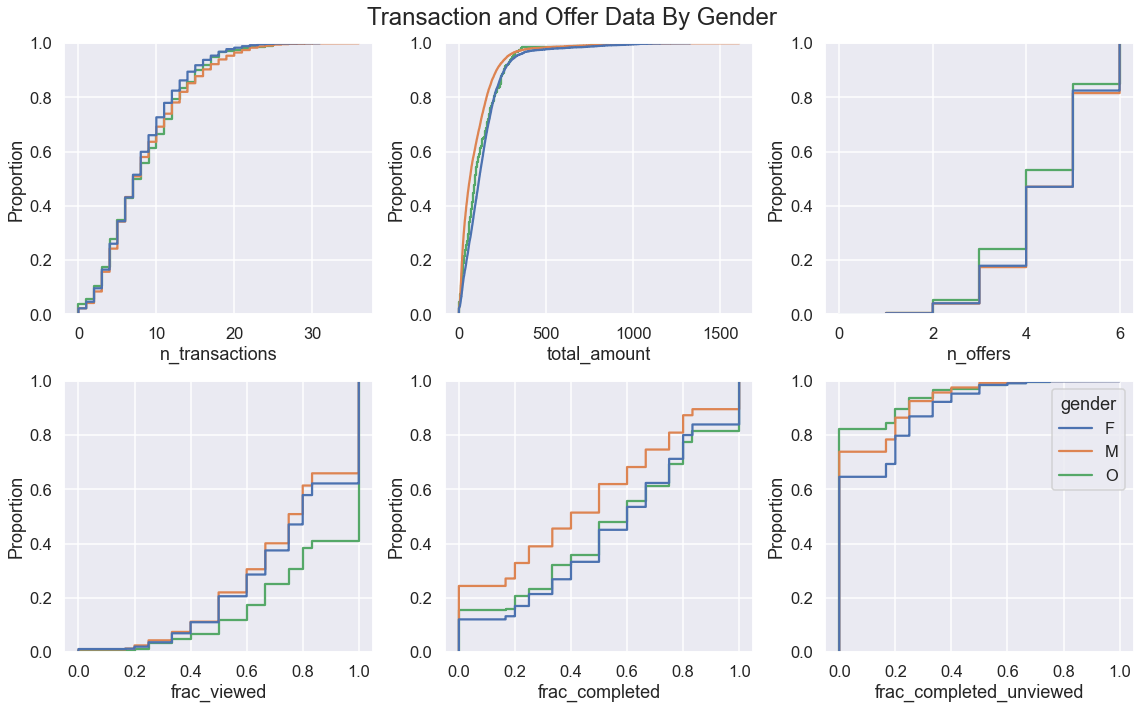

In [26]:
plot_transcript_vs_categorical(profile_extended, 'gender', "Transaction and Offer Data By Gender", False)

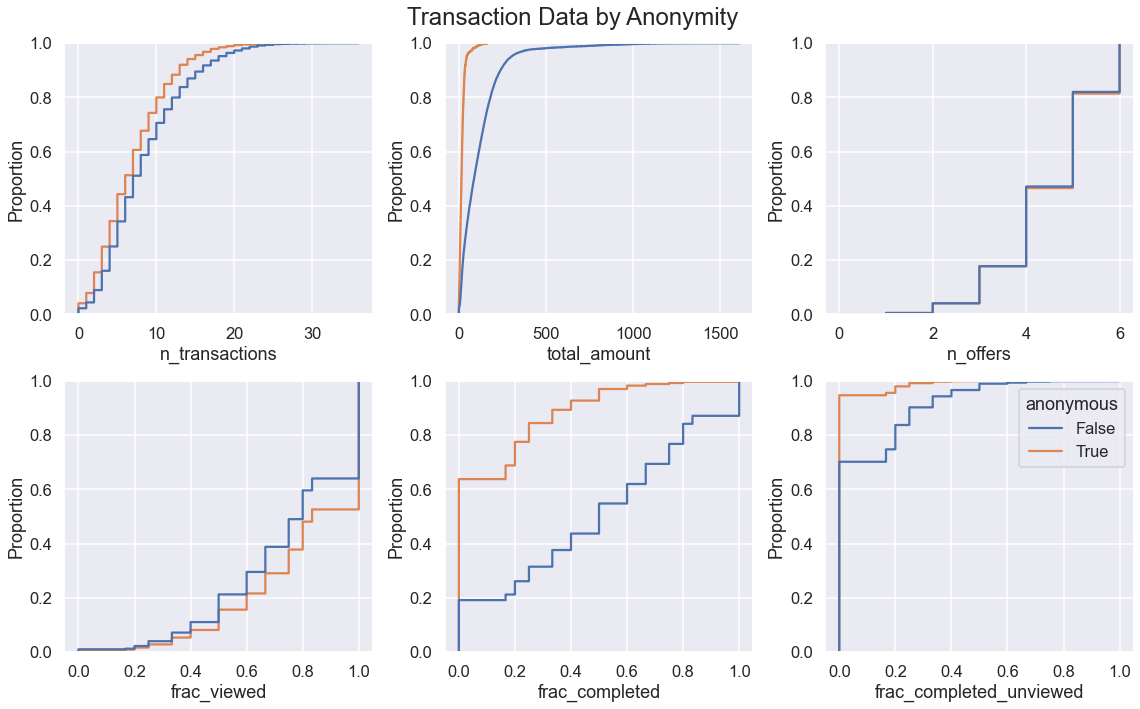

In [27]:
plot_transcript_vs_categorical(profile_extended, 'anonymous', "Transaction Data by Anonymity", False)

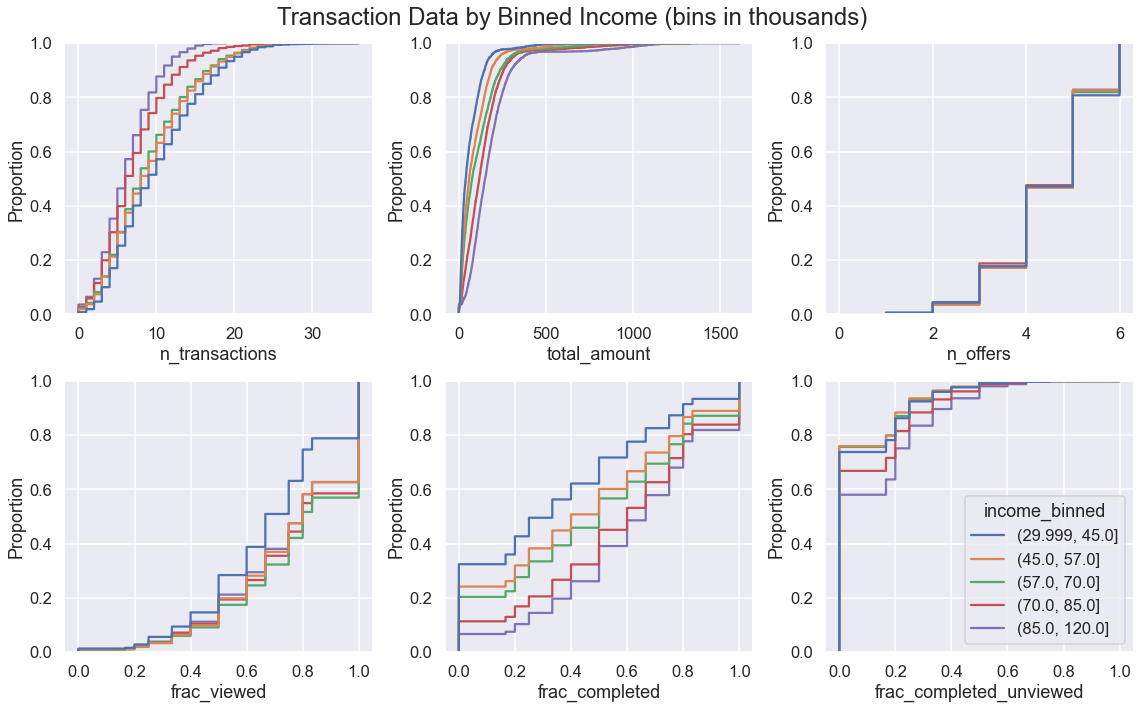

In [28]:
profile_extended.loc[~profile_extended.anonymous,'income_binned'] = \
                pd.qcut(profile_extended[~profile_extended.anonymous].income / 1000, 5)

order = profile_extended.income_binned.dropna().sort_values().unique()

plot_transcript_vs_categorical(profile_extended, 'income_binned', 
                               "Transaction Data by Binned Income (bins in thousands)", False, order)

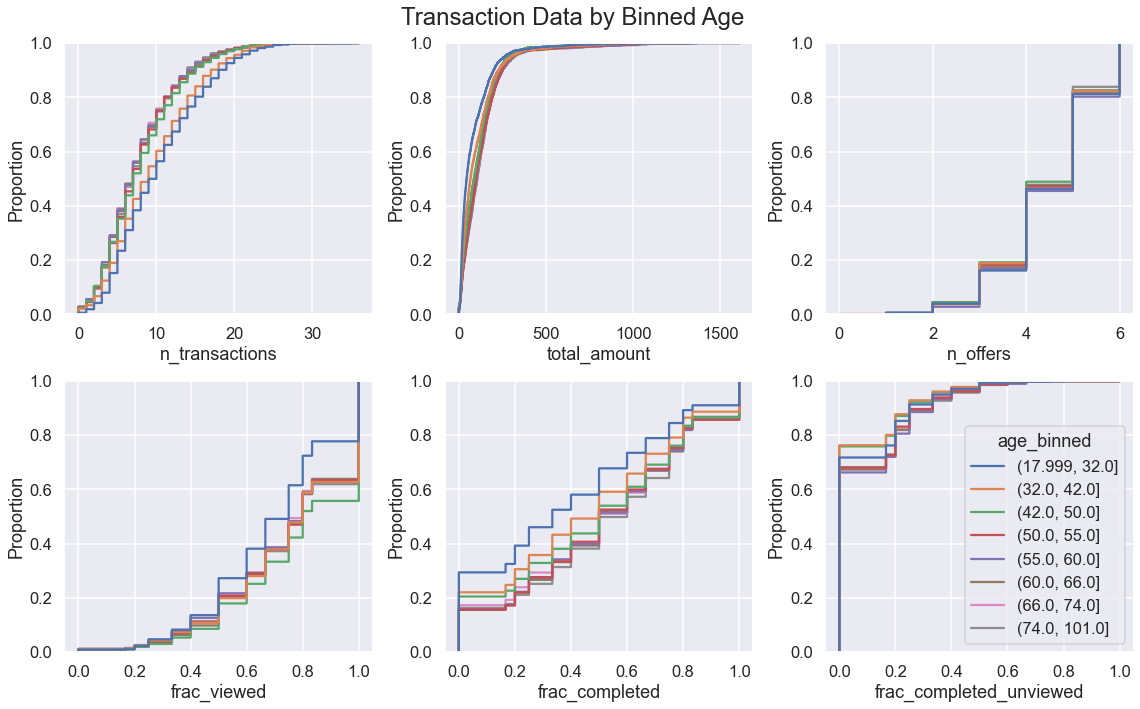

In [29]:
profile_extended.loc[~profile_extended.anonymous,'age_binned'] = \
                pd.qcut(profile_extended[~profile_extended.anonymous].age, 8)

order = profile_extended.age_binned.dropna().sort_values().unique()

plot_transcript_vs_categorical(profile_extended, 'age_binned', "Transaction Data by Binned Age", False, order)

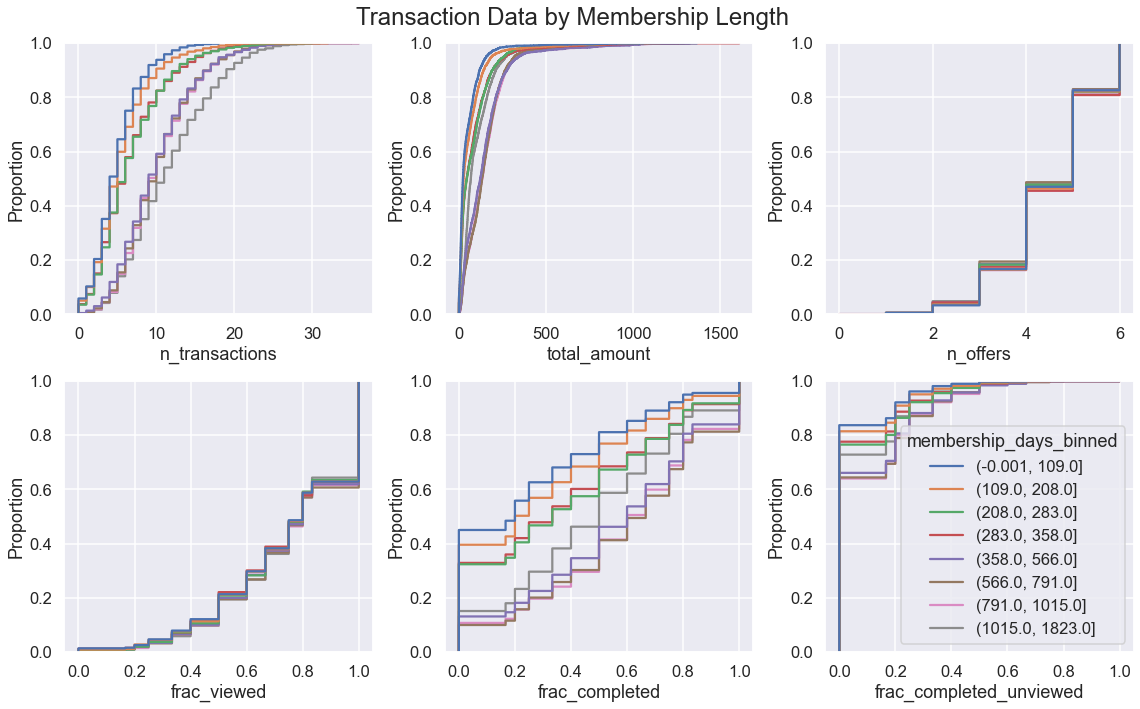

In [30]:
profile_extended['membership_days_binned'] = \
                pd.qcut(profile_extended.days_of_membership, 8)

order = profile_extended.membership_days_binned.dropna().sort_values().unique()

plot_transcript_vs_categorical(profile_extended, 'membership_days_binned',
                               "Transaction Data by Membership Length", False, order)

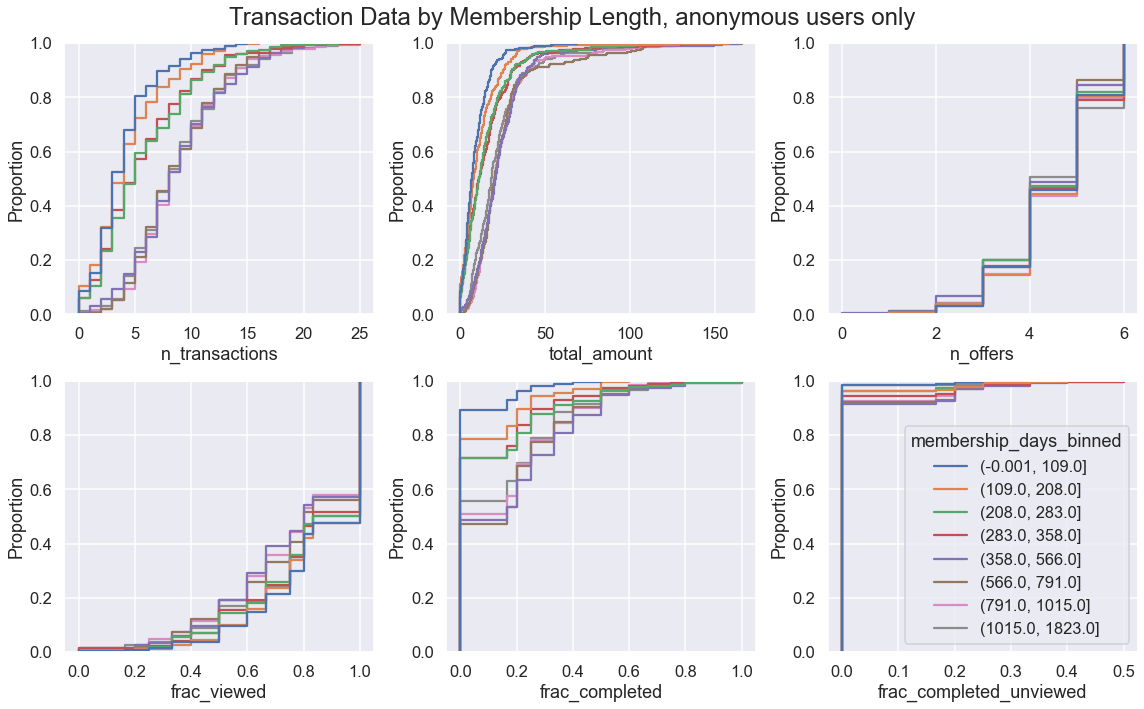

In [31]:
plot_transcript_vs_categorical(profile_extended[profile_extended.anonymous], 'membership_days_binned',
                               "Transaction Data by Membership Length, anonymous users only", False, order)

## Observations from exploratory data analysis on transaction and profile datasets

Note that all statements are based on the exploratory analysis only, and not a proper hypothesis test.  It is likely that not all of the observations below are statistically significant, and not all will be explored in this work.

#### Pairwise relationships on continuous variables
- A minor trend can be seen in income vs total transaction amounts (possibly with two groups - a larger and smaller total amount group).
- There is a minimum trend in n_transaction vs total amount.  Larger number of transactions increases the minimum value of total amount.
- There are also a number of unnatural-looking "corner edges" in the dataset, likely due to the setup of the simulation and the subgroups of users who were defined in it.  This is most prominent in the chart of income vs age.

#### Gender

- Women have slightly fewer total transactions than Men or Other.
- Women and Other spend slightly more in total than Men.
- People with Gender: Other are less likely to view offers than Men or Women.
- Men are less likely to complete offers than Women or Other.
- As a consequence of the above 2, Other are more likely to complete an offer unviewed than Men or Women.

#### Anonymity
Relative to users with a completed profile, 'anonymous' users:
- Have fewer transactions
- Spend less in total
- Are less likely to complete offers
- But are slightly more likely to view offers  

This makes them far less likely to complete an offer without viewing it than those with profiles.

#### Income
Many of the variables exhibit a nice gradational trend vs income.  Such as:
- Lower income users have more transactions than higher income users
- Higher income users spend more (higher total amount) than lower income users
- Higher income users are much more likely to complete an offer than lower income users
- Higher income users are more likely to complete an offer without viewing it than lower income users


#### Age
A similar set of gradational trends exist where:
- Younger users have more total transactions than older users
- Older users spend more in total than younger users
- Younger users are much likely to complete an offer than older users.
There aren't clear trends in completion without viewing and view fraction vs age.
Note also that many of the above could be a simple reflection of the relationship between age and income (the corners in the age/income trend).

#### Length of Membership
This set of gradational trends is the most striking yet.  
Relative to users with a shorter membership, longer-standing members:
- Have more total transactions
- Spend more
- Complete offers fare more
- But view offers at about the same rate
- Thus they are more likely to complete an offer without viewing it

These observations also hold for anonymous users.  This is very important since for anonymous users the only reliable data is length of membership.

# Combining the Transcript and Porfolio datasets (breakdown by offer)

In [32]:
offers_df.head()

,person,offer_id,time_received,viewed,time_viewed,completed,time_completed,completed_not_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,True,6.0,True,132.0,False
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,168,True,216.0,False,NaN,False
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408,True,408.0,True,510.0,False
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,True,582.0,True,510.0,False
4,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,True,6.0,False,NaN,False


In [33]:
times_received = offers_df.groupby('offer_id').size().rename('n_received')
times_viewed = offers_df.groupby('offer_id').viewed.sum().rename('n_viewed')
times_completed = offers_df.groupby('offer_id').completed.sum().rename('n_completed')
times_completed_unviewed = offers_df.groupby('offer_id').completed_not_viewed.sum().rename('n_completed_unviewed')
offers_df['viewed_after_completed'] = offers_df.time_completed < offers_df.time_viewed
times_completed_before_viewed = (offers_df.groupby('offer_id').viewed_after_completed
                                 .sum().rename('n_viewed_after_completed'))

In [34]:
# Extend the portfolio dataset in a separate dataframe for this exploratory analysis
portfolio_extended = portfolio.copy()

# Merge in the generated datasets
for extension in [times_received, times_viewed, times_completed, 
                  times_completed_unviewed, times_completed_before_viewed]:
    portfolio_extended = pd.merge(portfolio_extended, extension, left_on='id', right_index=True, how='left')

# Any NaNs in this new data indicate that the offer had zero (zero transactions, zero offers viewed, etc)
# Need to populate this in the dataframe
for column in ['n_received', 'n_viewed', 'n_completed', 'n_completed_unviewed', 'n_viewed_after_completed']:
    portfolio_extended[column] = portfolio_extended[column].fillna(0)


portfolio_extended['frac_viewed'] = portfolio_extended.n_viewed / portfolio_extended.n_received
portfolio_extended['frac_completed'] = portfolio_extended.n_completed / portfolio_extended.n_received
portfolio_extended['frac_completed_unviewed'] = \
            portfolio_extended.n_completed_unviewed / portfolio_extended.n_received
portfolio_extended['n_completed_viewed'] = (portfolio_extended.n_completed 
                                            - portfolio_extended.n_completed_unviewed 
                                            - portfolio_extended.n_viewed_after_completed)
portfolio_extended['frac_of_viewed_who_completed'] = \
portfolio_extended.n_completed_viewed / portfolio_extended.n_viewed

portfolio_extended

,reward,difficulty,duration,offer_type,id,channel_web,channel_email,channel_mobile,channel_social,n_received,n_viewed,n_completed,n_completed_unviewed,n_viewed_after_completed,frac_viewed,frac_completed,frac_completed_unviewed,n_completed_viewed,frac_of_viewed_who_completed
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,False,True,True,True,7658,6716,3688,440,637,0.876991,0.481588,0.057456,2611,0.388773
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,True,True,True,True,7593,7298,3331,90,475,0.961148,0.438694,0.011853,2766,0.379008
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,True,True,True,False,7617,4144,0,0,0,0.544046,0.000000,0.000000,0,0.000000
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,True,False,7677,4171,4354,1635,617,0.543311,0.567149,0.212974,2102,0.503956
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,True,False,False,7668,2663,3420,1843,257,0.347287,0.446009,0.240350,1320,0.495682
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,True,True,True,True,7646,7337,5156,165,602,0.959587,0.674340,0.021580,4389,0.598201
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,True,True,True,True,7597,7327,5317,145,515,0.964460,0.699882,0.019086,4657,0.635594
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,False,True,True,True,7618,6687,0,0,0,0.877789,0.000000,0.000000,0,0.000000
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,True,True,True,True,7571,7264,4296,137,626,0.959451,0.567428,0.018095,3533,0.486371
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,True,True,True,False,7632,4118,4017,1355,553,0.539570,0.526336,0.177542,2109,0.512142


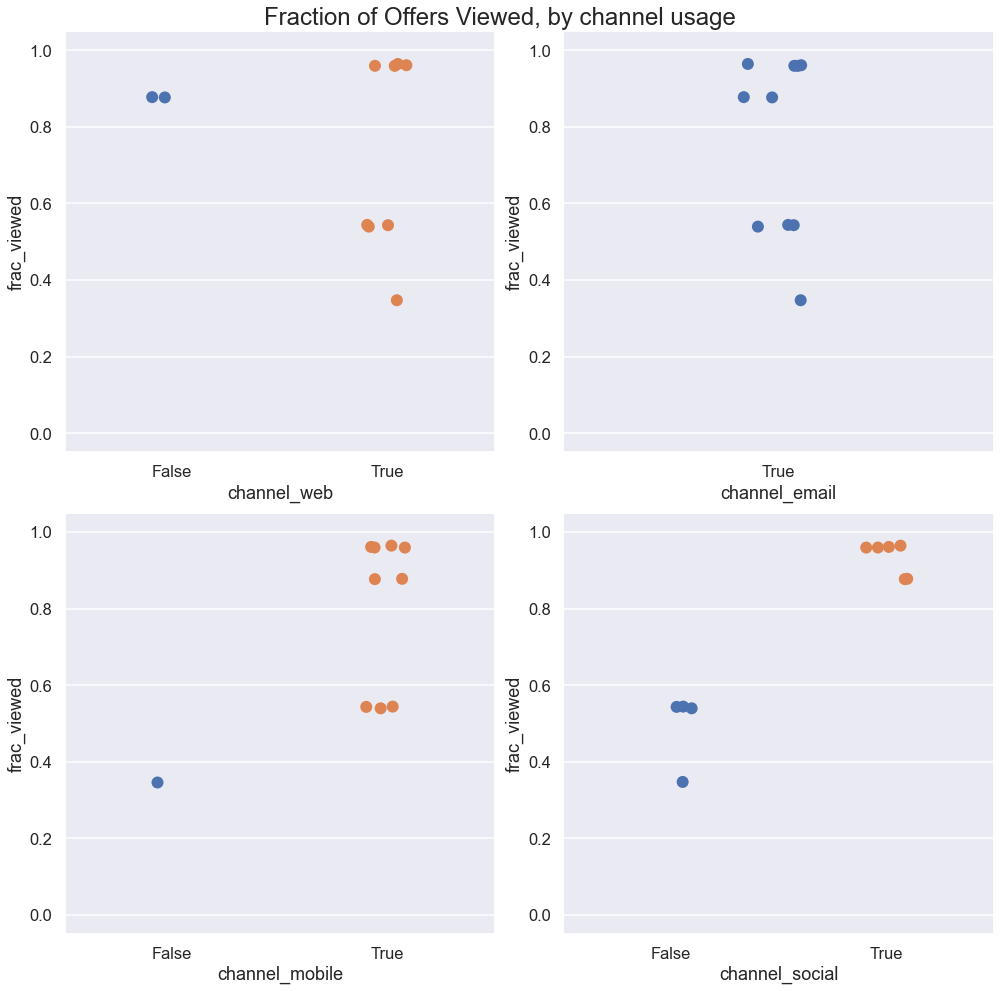

In [35]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
axs=axs.flatten()

sns.stripplot(data=portfolio_extended, x='channel_web', y='frac_viewed', ax=axs[0], s=12)
sns.stripplot(data=portfolio_extended, x='channel_email', y='frac_viewed', ax=axs[1], s=12)
sns.stripplot(data=portfolio_extended, x='channel_mobile', y='frac_viewed', ax=axs[2], s=12)
sns.stripplot(data=portfolio_extended, x='channel_social', y='frac_viewed', ax=axs[3], s=12)
[ax.set(ylim=[-0.05,1.05]) for ax in axs];

f.suptitle("Fraction of Offers Viewed, by channel usage", fontsize=24)
plt.tight_layout();

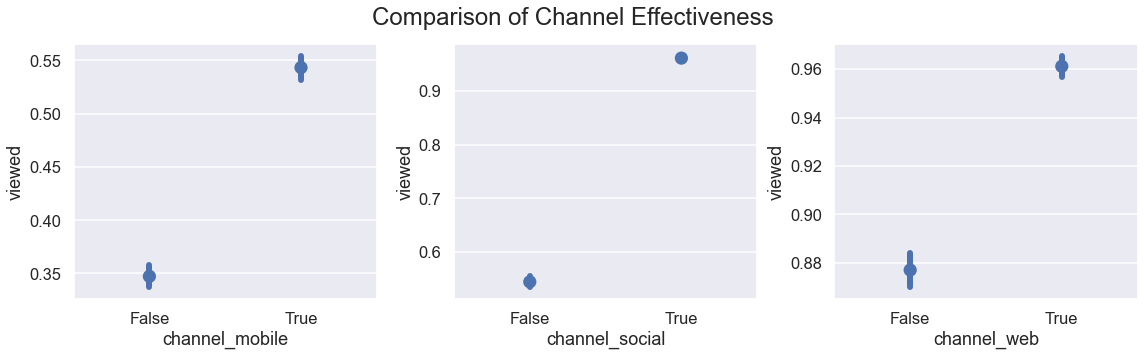

In [36]:
# Make a comparision in view rates for two offers who were identical except for one channel
# and see if Confidence Intervals overlap
channel_checks = {'channel_mobile':['0b1e1539f2cc45b7b9fa7c272da2e1d7', '9b98b8c7a33c4b65b9aebfe6a799e6d9'],
            'channel_social':['3f207df678b143eea3cee63160fa8bed', '4d5c57ea9a6940dd891ad53e9dbe8da0'],
            'channel_web': ['ae264e3637204a6fb9bb56bc8210ddfd', '4d5c57ea9a6940dd891ad53e9dbe8da0']}

offers_df_tmp = pd.merge(offers_df, portfolio, left_on='offer_id', right_on='id', how='left')

f, axs = plt.subplots(ncols=3, figsize=(16,5))
axs = axs.flatten()

for i, channel in enumerate(channel_checks.keys()):
    sns.pointplot(data=offers_df_tmp[offers_df_tmp.offer_id.isin(channel_checks[channel])],
             x=channel, y='viewed', join=False, ci=95, errwidth=6, ax=axs[i]);

f.suptitle('Comparison of Channel Effectiveness', fontsize=24)
plt.tight_layout()

In [37]:
offers_df

,person,offer_id,time_received,viewed,time_viewed,completed,time_completed,completed_not_viewed,viewed_after_completed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,True,6.0,True,132.0,False,False
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,168,True,216.0,False,NaN,False,False
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408,True,408.0,True,510.0,False,False
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,True,582.0,True,510.0,False,True
4,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,True,6.0,False,NaN,False,False
...,...,...,...,...,...,...,...,...,...
76272,9fcbff4f8d7241faa4ab8a9d19c8a812,3f207df678b143eea3cee63160fa8bed,504,True,504.0,False,NaN,False,False
76273,9fcbff4f8d7241faa4ab8a9d19c8a812,4d5c57ea9a6940dd891ad53e9dbe8da0,576,True,576.0,False,NaN,False,False
76274,ebae5093b436466c9fbd097cb7434023,fafdcd668e3743c1bb461111dcafc2a4,576,True,588.0,True,660.0,False,False
76275,912b9f623b9e4b4eb99b6dc919f09a93,4d5c57ea9a6940dd891ad53e9dbe8da0,576,True,594.0,False,NaN,False,False


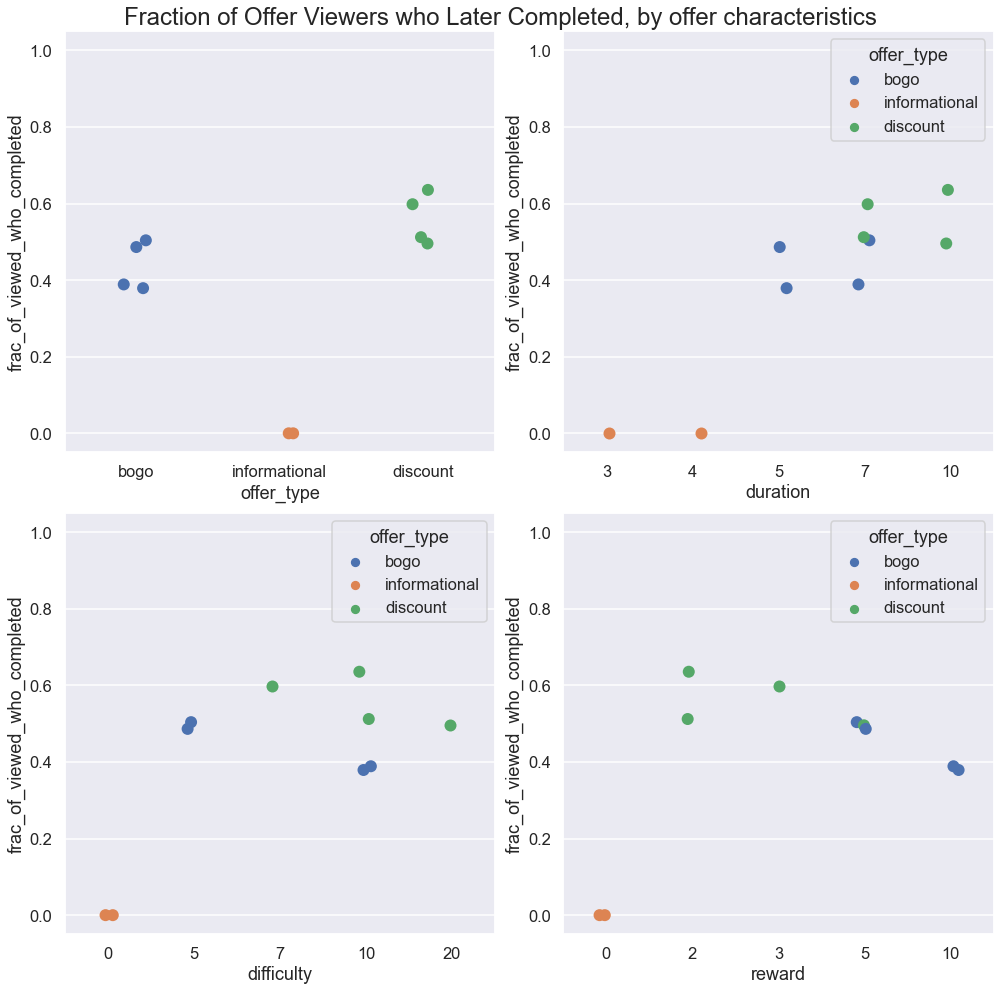

In [38]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
axs=axs.flatten()

sns.stripplot(data=portfolio_extended, x='offer_type', y='frac_of_viewed_who_completed', ax=axs[0], s=12)
sns.stripplot(data=portfolio_extended, x='duration', y='frac_of_viewed_who_completed',
              hue='offer_type', ax=axs[1], s=12)
sns.stripplot(data=portfolio_extended, x='difficulty', y='frac_of_viewed_who_completed',
              hue='offer_type', ax=axs[2], s=12)
sns.stripplot(data=portfolio_extended, x='reward', y='frac_of_viewed_who_completed',
              hue='offer_type', ax=axs[3], s=12)
[ax.set(ylim=[-0.05,1.05]) for ax in axs];

f.suptitle("Fraction of Offer Viewers who Later Completed, by offer characteristics", fontsize=24)
plt.tight_layout();

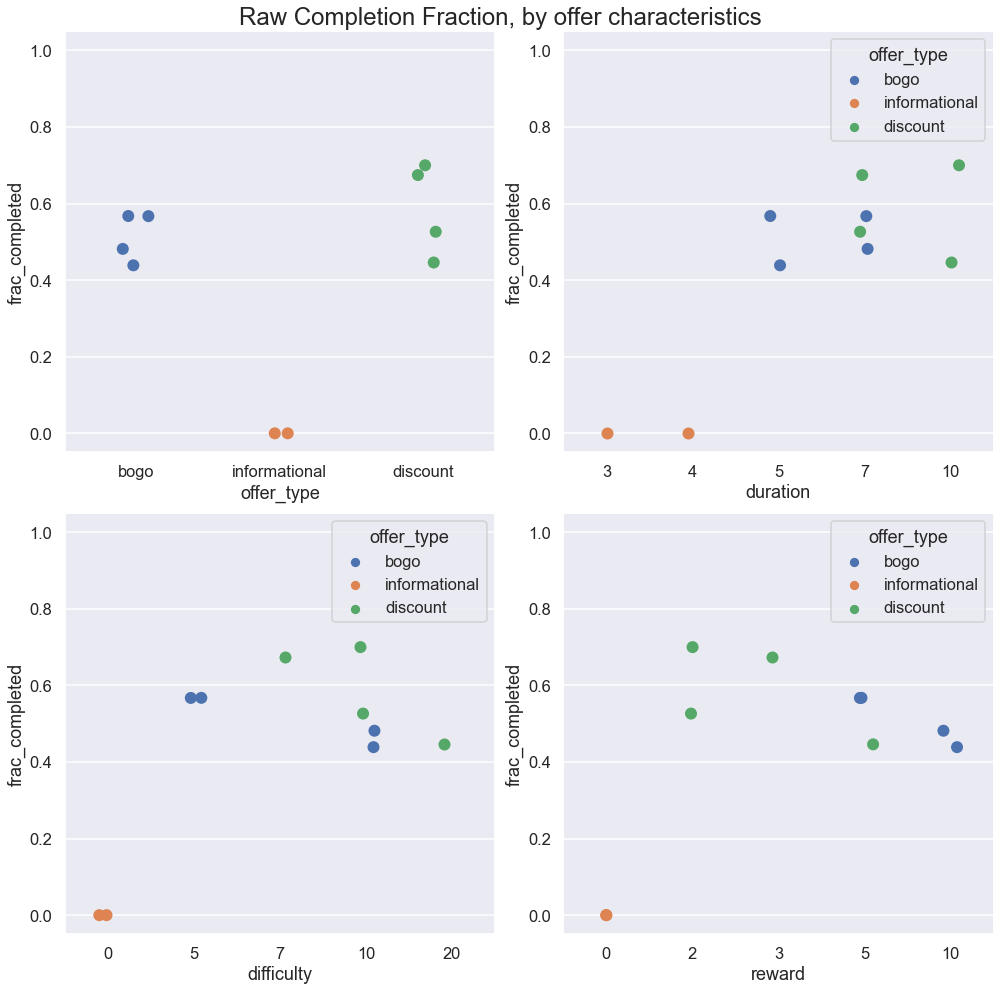

In [39]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
axs=axs.flatten()

sns.stripplot(data=portfolio_extended, x='offer_type', y='frac_completed', ax=axs[0], s=12)
sns.stripplot(data=portfolio_extended, x='duration', y='frac_completed',
              hue='offer_type', ax=axs[1], s=12)
sns.stripplot(data=portfolio_extended, x='difficulty', y='frac_completed',
              hue='offer_type', ax=axs[2], s=12)
sns.stripplot(data=portfolio_extended, x='reward', y='frac_completed',
              hue='offer_type', ax=axs[3], s=12)
[ax.set(ylim=[-0.05,1.05]) for ax in axs];

f.suptitle("Raw Completion Fraction, by offer characteristics", fontsize=24)
plt.tight_layout();

/opt/anaconda3/envs/dsnd-tf/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/dsnd-tf/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/dsnd-tf/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/dsnd-tf/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


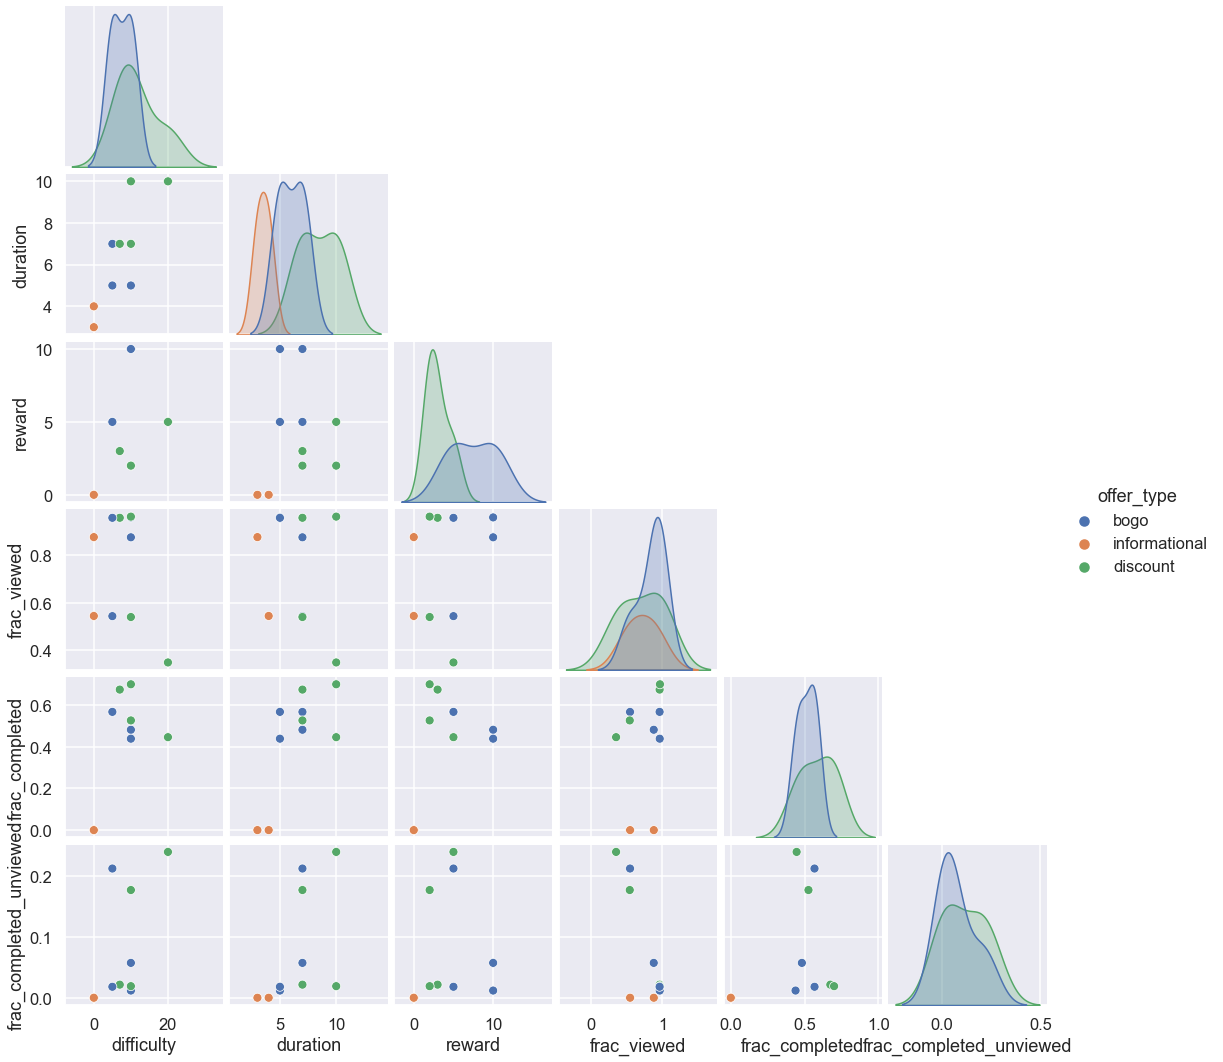

In [77]:
# Nothing new in the pairwise trends on this data - but have to plot it to know that
sns.pairplot(data=portfolio_extended.loc[:,['difficulty', 'duration', 'reward', 'offer_type',
                                          'frac_viewed', 'frac_completed', 'frac_completed_unviewed']],
             hue='offer_type', corner=True);

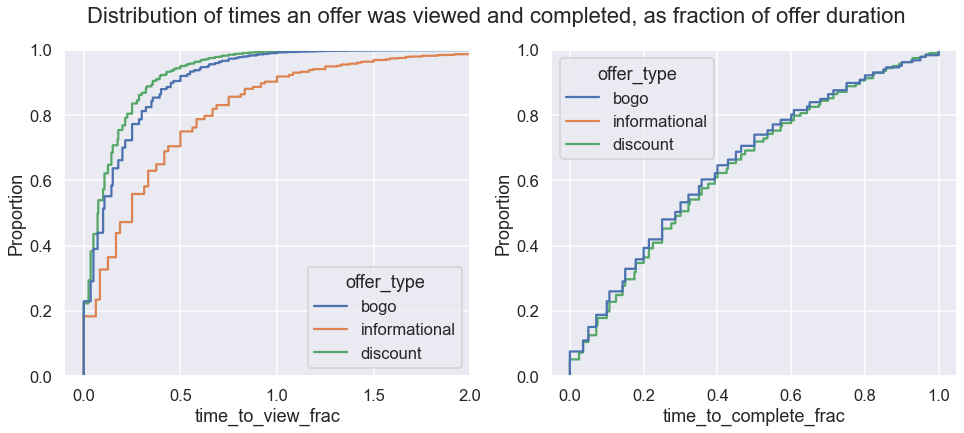

In [41]:
offers_df_ext = pd.merge(offers_df, portfolio, left_on='offer_id', right_on='id', how='left')
offers_df_ext['time_to_view'] = offers_df_ext.time_viewed - offers_df_ext.time_received
offers_df_ext['time_to_view_frac'] = offers_df_ext.time_to_view / (offers_df_ext.duration * 24)
offers_df_ext['time_to_complete'] = offers_df_ext.time_completed - offers_df_ext.time_received
offers_df_ext['time_to_complete_frac'] = offers_df_ext.time_to_complete / (offers_df_ext.duration * 24)
offers_df_ext['view_to_complete_frac'] = \
            (offers_df_ext.time_to_complete - offers_df_ext.time_to_view) / (offers_df_ext.duration * 24)
f, axs = plt.subplots(ncols=2, figsize=(16,6))
axs = axs.flatten()
sns.ecdfplot(data=offers_df_ext, x='time_to_view_frac', hue='offer_type', ax=axs[0])
axs[0].set(xlim=[-0.1,2])
sns.ecdfplot(data=offers_df_ext, x='time_to_complete_frac', hue='offer_type', ax=axs[1])
f.suptitle("Distribution of times an offer was viewed and completed, as fraction of offer duration", fontsize=22);

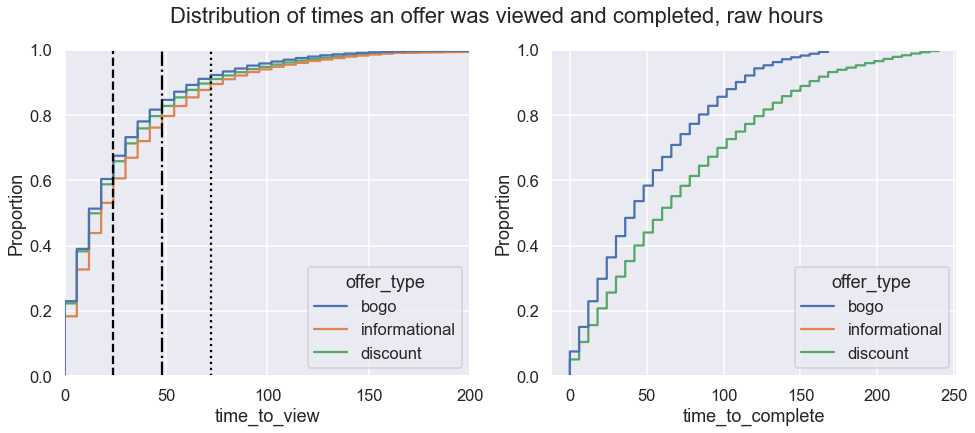

In [42]:
f, axs = plt.subplots(ncols=2, figsize=(16,6))
axs = axs.flatten()
sns.ecdfplot(data=offers_df_ext, x='time_to_view', hue='offer_type', ax=axs[0])
axs[0].axvline(24, color='black', ls='--')
axs[0].axvline(48, color='black', ls='-.')
axs[0].axvline(72, color='black', ls=':')
axs[0].set(xlim=[-0.1, 200])
sns.ecdfplot(data=offers_df_ext, x='time_to_complete', hue='offer_type', ax=axs[1])
f.suptitle("Distribution of times an offer was viewed and completed, raw hours", fontsize=22);

In [43]:
print("Fraction of completed 10-day offers that were completed after day 7:",
      (offers_df_ext[offers_df_ext.duration==10].time_to_complete > 7*24).sum() / 
      offers_df_ext[offers_df_ext.duration==10].completed.sum())

Fraction of completed 10-day offers that were completed after day 7: 0.13929266338560148


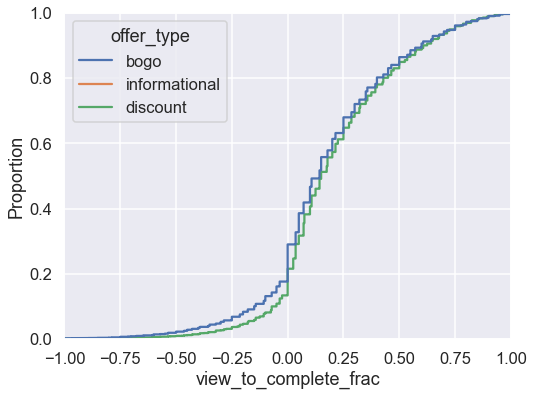

In [44]:
f, ax = plt.subplots(figsize=(8,6))
sns.ecdfplot(data=offers_df_ext,
             x='view_to_complete_frac', hue='offer_type', ax=ax)
ax.set(xlim=[-1,1]);

In [127]:
# Confirm that these completions before view are real and not a bug
offers_rev[offers_rev.time_completed < offers_rev.time_viewed][['person', 'offer_id', 'time_received']].head()

,person,offer_id,time_received
34,f082d80f0aac47a99173ba8ef8fc1909,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
58,fe8264108d5b4f198453bbb1fa7ca6c9,ae264e3637204a6fb9bb56bc8210ddfd,0
98,1c587de019994f93a242c6864fd7bc55,ae264e3637204a6fb9bb56bc8210ddfd,0
106,92e07c49ee7448fca6e48df0c96e3eec,ae264e3637204a6fb9bb56bc8210ddfd,0
132,5404741ead9442bdbd4b9aa2273e85af,2298d6c36e964ae4a3e7e9706d1fb8c2,0


In [128]:
# take transcript of the first person
transcript[(transcript.person=='f082d80f0aac47a99173ba8ef8fc1909')]

,person,event,value,time,offer_id,amount
21,f082d80f0aac47a99173ba8ef8fc1909,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
18068,f082d80f0aac47a99173ba8ef8fc1909,transaction,{'amount': 5.47},12,NaN,5.47
18069,f082d80f0aac47a99173ba8ef8fc1909,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,12,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
24220,f082d80f0aac47a99173ba8ef8fc1909,transaction,{'amount': 6.18},30,NaN,6.18
29498,f082d80f0aac47a99173ba8ef8fc1909,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},48,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
35541,f082d80f0aac47a99173ba8ef8fc1909,transaction,{'amount': 1.54},72,NaN,1.54
40780,f082d80f0aac47a99173ba8ef8fc1909,transaction,{'amount': 11.13},96,NaN,11.13
45430,f082d80f0aac47a99173ba8ef8fc1909,transaction,{'amount': 1.69},120,NaN,1.69
48533,f082d80f0aac47a99173ba8ef8fc1909,transaction,{'amount': 0.28},138,NaN,0.28
53197,f082d80f0aac47a99173ba8ef8fc1909,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837,NaN


## Observations from exploratory data analysis on transcript and portfolio datasets


### Offer Performance

#### Offer Views

Inspection of the performance of the different offers reveals marked difference.  One offer in particular, `0b1e15`, was completed more times without being viewed (1843) than it was after being viewed (1320)!!  Clearly the rewards given out with this offer are not very effective in bringing customers into the store.  At first glance, this would appear to be a very bad offer.

Upon a closer look, this poor performance is driven primarily by a very low number of views.  For this project, we will assume users do not know the content of an offer before they view it.  While this may seem obvious, with some channels -  users may know the content of an offer before viewing.  The offer's content could be clear from a phone notification on their home screen, the subject line of an email, or a thumbnail on a website without the user actually viewing the offer in-app, opening the email, or clicking on the offer on the website.

When comparing to channel usage, the low view count for offer `0b1e15` makes sense - it uses the fewest channels.  Offers that did not user the mobile and social channels showed much lower view rates than offers that did.  The web channel seems to have a smaller impact, and all offers used the email channel so we can't make any inferences about its effectiveness.

The effectiveness of each channel can be examined more statistically by finding offers which have only 1 difference in the channels used.  Applying this method showed that the confidence intervals do not overlap for any of the differences in view rate and thus the impact of channel usage on offer viewing is statistical for all channels that can be evaluated (social, web, mobile).

#### Offer Attractiveness

Fraction of offers completed is not a good metric to use for evaluating the attractiveness of an offer to a user.  This is because there are dramatic differences in the rate at which an offer is viewed, due to the use of different channels.

Within this particular dataset, the best look at offer attractiveness is the view->complete fraction.  

To be more specific, for a given offer this is:

View->Complete Fraction = (N_Completions - N_Completions_Unviewed - N_Completions_Before_View) / N_Views

Users are not attracted to an offer if they haven't viewed it, so it makes sense to use the number of views in the denominator for this as opposed to the number of total offers.  For the numerator, the number of offer completions needs to be adjusted to account for users who completed the offer without being influenced by it - either by completing it unviewed or by completing it before they viewed it.

Using the view->complete fraction instead of raw offer completion fraction makes the largest difference for 10-day discount offer mentioned earlier (`0b1e15`) but otherwise does not change the offer ranking much:

Observations:
- The 10-for-10 BOGO offers have the lowest view->complete fraction, despite offering the highest total reward.
- Discount offers seem to perform slightly better but the difference is slight and it is difficult to compare because the rest of the parameters are also changing which confounds comparison.

#### Timing of offer view and completion

Users do not distinguish between offer types when opening an offer in terms of time - the 'time_viewed' curves are nearly identical for all offer types.

Characteristics:
- Over 50% of offer views occur in the first day
- Approximately 80% of offer views occur in the first 2 days
- Approximately 90% of offer views occur in the first 3 days

Users do seem make a distinction on offer duration as far as pushing to complete.  The offer completion curves overlay each other when normalized as fraction of offer duration.  This implies the users are somewhat influenced by the remaining time on the offer.

There is a lot of focus in the problem description about users who complete an offer without viewing it.  It is true, there are many offers which are completed and are never viewed.  But this perspective is still too simple.  Among users who viewed and offer and completed the same offer, around 20% of them viewed the offer after completing it.  This scenario must also be considered in terms of whether the user was influenced by the offer.

# Evaluating the Revenue Impact

We will define the offer's "influence period" as 10-days after the offer is sent.  A whole study could be done (and may have been done) to determine what this influence period likely is.  However, that is not the focus at the moment.

10 days is chosen because:
- Shorter durations do not allow comparisons across offers.  Over 10% of 10-day offer completions occur after day 7, so choosing 7 days would exclude a menaingful amount of influence from the longer offers.
- Longer durations heavily limit the dataset.  The offers were sent at 0, 7, 14, 17, 21 and 24 days, and the last transaction is just before day 30.  With a 10-day influence period, the only the day-21 and day-24 campaigns need to be excluded from the analysis.  With a 14-day influence period, the day-17 campaign must be excluded as well which now throws out half the dataset.
- Linking the duration to offer view time instead of offer send time exacerbates the dataset-limiting problem.  If we use 10-days after viewing the offer, likely only the day-0 and day-7 campaigns could be used.
- Choosing influence period = offer duration is an option, but this is not adequate for the informational offers.  Almost all of the views for discount or bogo offers occur during the offer duration.  Informational offers, on the other hand, have almost 10% of the views occurring after the offer duration.  In addition, there is also the option of not sending an offer at all.  What would the 'offer duration' of no offer be?

In [45]:
# add in the possibility of no offer to the portfolio dataframe
portfolio = pd.concat([portfolio,
         pd.DataFrame(data=[[0, 0, 0, 'none', 'no_offer', False, False, False, False]],
                     columns=portfolio.columns)], axis=0)
portfolio

,reward,difficulty,duration,offer_type,id,channel_web,channel_email,channel_mobile,channel_social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,False,True,True,True
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,True,True,True,True
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,True,True,True,False
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,True,False
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,True,False,False
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,True,True,True,True
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,True,True,True,True
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,False,True,True,True
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,True,True,True,True
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,True,True,True,False


In [46]:
# add in the users who did not get an offer for each phase of the campaign

# set up a list to store time slices of the dataframe
df_slices = []

# iterate through the campaign times
for time in offers_df.time_received.unique():
    # limit the offers dataframe to the time in question
    df_slice = offers_df[offers_df.time_received == time].copy()
    # get a copy of the users dataframe and set time_received to the current time
    tmp = profile.copy()
    tmp['time_received'] = time
    # left join the users dataframe to the current time slice and remove the duplicate ID column
    df_slice = pd.merge(tmp, df_slice, left_on=['id', 'time_received'],
                        right_on=['person', 'time_received'], how='left')
    df_slice.drop(columns=['person'], inplace=True)
    df_slice.rename(columns={'id': 'person'}, inplace=True)
    # all NaNs in the offer info refer to people who did not get an offer
    df_slice['offer_id'] = df_slice['offer_id'].fillna('no_offer')
    for column in ['viewed', 'completed', 'completed_not_viewed', 'viewed_after_completed']:
        df_slice[column] = df_slice[column].fillna(False)
    
    df_slices.append(df_slice)
    
offers_df_old = offers_df.copy()
    
offers_df = pd.concat(df_slices, axis=0)
offers_df.shape

(102000, 15)

In [47]:
# establish the offer presentation ID as the index of the current offers DF
offers_df = offers_df.reset_index().drop(columns='index').reset_index().rename(columns={'index': 'offer_presentation_id'})
offers_df.head()

,offer_presentation_id,gender,age,person,became_member_on,income,days_of_membership,anonymous,time_received,offer_id,viewed,time_viewed,completed,time_completed,completed_not_viewed,viewed_after_completed
0,0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,529,True,0,no_offer,False,NaN,False,NaN,False,False
1,1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376,False,0,no_offer,False,NaN,False,NaN,False,False
2,2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,14,True,0,no_offer,False,NaN,False,NaN,False,False
3,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443,False,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,6.0,True,132.0,False,False
4,4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,356,True,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,6.0,False,NaN,False,False


In [51]:
# calculate the ten-day revenue of each offer presentation
dict_ten_day_revenues = {'person':[], 'time_received': [], 'ten_day_revenue': []}

transcript_transactions = transcript[transcript.event=='transaction']

#iterate through the people
for person in progressbar.progressbar(profile.id):
    #pull this person's transactions transcript
    transcript_person = transcript_transactions[transcript_transactions.person==person].copy().sort_index()
    # initialize results for each offer delivery time
    revenues_person = {0: 0.0, 168:0.0, 336:0.0, 408:0.0, 504:0.0, 576:0.0}
    # iterate through the rows in the transcript
    for _, tmp in transcript_person.iterrows():
        # iterate through delivery times
        for delivery_time in revenues_person.keys():
            # if after delivery time and before delivery_time + 10
            if tmp.time >= delivery_time and tmp.time <= (delivery_time + 24*10):
                # add to the delivery times
                revenues_person[delivery_time] += tmp.amount
    #unroll into results dict
    for delivery_time in revenues_person.keys():
        dict_ten_day_revenues['person'].append(person)
        dict_ten_day_revenues['time_received'].append(delivery_time)
        dict_ten_day_revenues['ten_day_revenue'].append(revenues_person[delivery_time])

100% (17000 of 17000) |##################| Elapsed Time: 0:03:07 Time:  0:03:07


In [52]:
ten_day_revenues = pd.DataFrame.from_dict(dict_ten_day_revenues)
ten_day_revenues.head()

,person,time_received,ten_day_revenue
0,68be06ca386d4c31939f3a4f0e3dd783,0,0.00
1,68be06ca386d4c31939f3a4f0e3dd783,168,0.35
2,68be06ca386d4c31939f3a4f0e3dd783,336,10.52
3,68be06ca386d4c31939f3a4f0e3dd783,408,14.84
4,68be06ca386d4c31939f3a4f0e3dd783,504,17.42


In [53]:
# merge the ten-day revenues back into the offers dataframe
offers_rev = pd.merge(offers_df, ten_day_revenues, on=['person', 'time_received'], how='left')
offers_rev = pd.merge(offers_rev, portfolio, left_on='offer_id', right_on='id', how='left')
offers_rev.head()

,offer_presentation_id,gender,age,person,became_member_on,income,days_of_membership,anonymous,time_received,offer_id,...,ten_day_revenue,reward,difficulty,duration,offer_type,id,channel_web,channel_email,channel_mobile,channel_social
0,0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,529,True,0,no_offer,...,0.00,0,0,0,none,no_offer,False,False,False,False
1,1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376,False,0,no_offer,...,53.79,0,0,0,none,no_offer,False,False,False,False
2,2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,14,True,0,no_offer,...,1.34,0,0,0,none,no_offer,False,False,False,False
3,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443,False,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,87.06,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,True,False
4,4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,356,True,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,1.09,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,True,False,False


In [54]:
# calculate the ten-day profit and ten-day profit with offer reward subtracted
offers_rev['ten_day_profit'] = offers_rev.ten_day_revenue * 0.25
offers_rev['ten_day_profit_minus_reward'] = \
        offers_rev.ten_day_revenue * 0.25 - offers_rev.reward * offers_rev.completed

# Test as an A/B Test

To analyze the test as an A/B test the invariant metrics must be checked to ensure the randomization was proper, then the profit results can be compared across offers.

In [60]:
offers_df.head()

,offer_presentation_id,gender,age,person,became_member_on,income,days_of_membership,anonymous,time_received,offer_id,viewed,time_viewed,completed,time_completed,completed_not_viewed,viewed_after_completed
0,0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,529,True,0,no_offer,False,NaN,False,NaN,False,False
1,1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376,False,0,no_offer,False,NaN,False,NaN,False,False
2,2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,14,True,0,no_offer,False,NaN,False,NaN,False,False
3,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443,False,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,6.0,True,132.0,False,False
4,4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,356,True,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,6.0,False,NaN,False,False


In [61]:
props = {'gender': {'M':[], 'F':[], 'O':[]},
         'anonymous': {True:[]}
}

# 5000 bootstrap iterations
for i in progressbar.progressbar(range(5000)):
    # sample the average number of copies of the same offer sent
    boot = profile.sample(n=7627, axis=0, replace=True)
    # iterate through the desired columns
    for column in props.keys():
        # group by the column
        boot_grp = boot.groupby(by=column).size()
        # iterate through the values in the column and add to the results
        for value in props[column].keys():
            props[column][value].append(boot_grp[value] / boot_grp.sum())

100% (5000 of 5000) |####################| Elapsed Time: 0:00:14 Time:  0:00:14


In [62]:
props_CI = {
    'male': [np.percentile(props['gender']['M'], 2.5), np.percentile(props['gender']['M'], 97.5)],
    'female': [np.percentile(props['gender']['F'], 2.5), np.percentile(props['gender']['F'], 97.5)],
    'other': [np.percentile(props['gender']['O'], 2.5), np.percentile(props['gender']['O'], 97.5)],
    'anon': [np.percentile(props['anonymous'][True], 2.5), np.percentile(props['anonymous'][True], 97.5)]
}

In [63]:
gender_overall = profile.groupby(by='gender')['id'].count()
prop_male_overall = gender_overall['M']/gender_overall.sum()
prop_female_overall = gender_overall['F']/gender_overall.sum()
prop_other_overall = gender_overall['O']/gender_overall.sum()
anon_overall = profile.groupby(by='anonymous')['id'].count()
prop_anon_overall = anon_overall[True]/profile.shape[0]

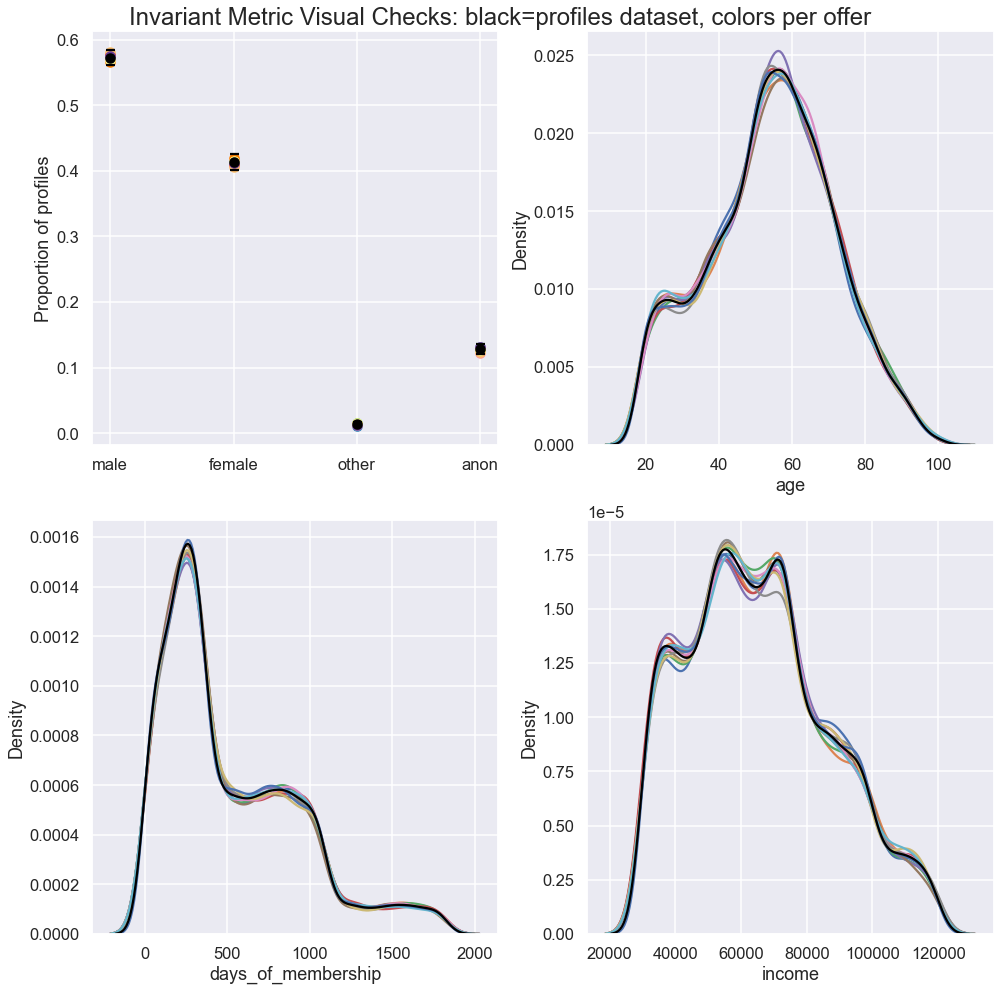

In [64]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
axs = axs.flatten()
palette = sns.color_palette('Paired')

# iterate through the offers
for i, offer in enumerate(portfolio.id.values):
    # calculate ratios between groups for the offer and divide by profiles dataset value
    offer_gender = offers_df[offers_df.offer_id==offer].groupby(by='gender').size()
    prop_male = offer_gender['M'] / offer_gender.sum()
    prop_female = offer_gender['F'] / offer_gender.sum()
    prop_other = offer_gender['O'] / offer_gender.sum()
    offer_anon = offers_df[offers_df.offer_id==offer].groupby(by='anonymous').size()
    prop_anon = offer_anon[True] / offer_anon.sum()
    axs[0].scatter(['male', 'female', 'other', 'anon'], 
                   [prop_male, prop_female, prop_other, prop_anon],
                   color=palette[i])
    # density plot of other key profile metrics
    sns.kdeplot(data=offers_df[(offers_df.offer_id==offer) & (~offers_df.anonymous)], x='age', ax=axs[1])
    sns.kdeplot(data=offers_df[offers_df.offer_id==offer], x='days_of_membership', ax=axs[2])
    sns.kdeplot(data=offers_df[offers_df.offer_id==offer], x='income', ax=axs[3])
    
# plot profiles dataset values last
for x_value in props_CI.keys():
    axs[0].scatter([x_value] * 2, props_CI[x_value], color='black', marker="_")
axs[0].scatter(['male', 'female', 'other', 'anon'], 
             [prop_male_overall, prop_female_overall, prop_other_overall, prop_anon_overall],
             color='black')
axs[0].set(ylabel='Proportion of profiles')
sns.kdeplot(data=profile[~profile.anonymous], x='age', ax=axs[1], color='black')
sns.kdeplot(data=profile, x='days_of_membership', ax=axs[2], color='black')
sns.kdeplot(data=profile, x='income', ax=axs[3], color='black')
f.suptitle('Invariant Metric Visual Checks: black=profiles dataset, colors per offer', fontsize=24)
plt.tight_layout();

In [65]:
# bootstrap the dataset again to check the means of the continuous variables
means = {
    'age': [],
    'income': [],
    'days_of_membership': []
}

for i in progressbar.progressbar(range(5000)):
    boot = profile.sample(n=10000, axis=0, replace=True)
    for variable in means.keys():
        means[variable].append(boot[variable].mean())

100% (5000 of 5000) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


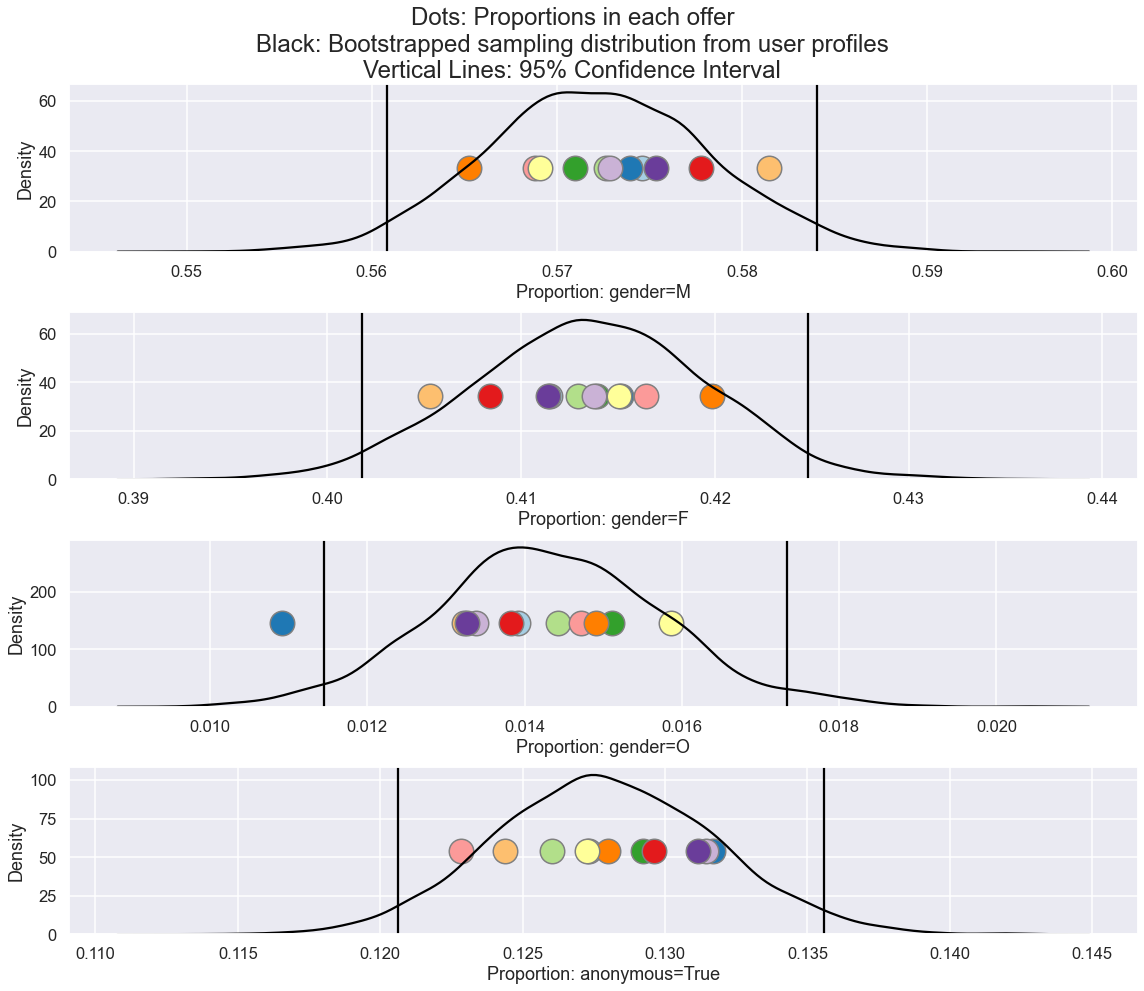

In [66]:
## Plot sampling distributions by invariant metric and compare to offer averages
f, axs = plt.subplots(nrows=4, figsize=(16,14))
axs = axs.flatten()

i = 0
for column in props.keys():
    for value in props[column].keys():
        sns.kdeplot(data=props[column][value], ax=axs[i], color='black')
        axs[i].axvline(np.percentile(props[column][value], 2.5), color='black')
        axs[i].axvline(np.percentile(props[column][value], 97.5), color='black')
        axs[i].set(xlabel='Proportion: ' + str(column) +"=" + str(value))
        for j, offer in enumerate(portfolio.id.unique()):
            grouped = offers_df[offers_df.offer_id==offer].groupby(column).size()
            axs[i].scatter(grouped[value]/grouped.sum(), np.mean(axs[i].get_ylim()),
                          color=palette[j], s=600, edgecolors='grey')
        i += 1

f.suptitle('Dots: Proportions in each offer\n' + 
           'Black: Bootstrapped sampling distribution from user profiles\n' +
           'Vertical Lines: 95% Confidence Interval', fontsize=24)
plt.tight_layout()

In [67]:
# bootstrap the dataset again to check the means of the continuous variables
means = {
    'age': [],
    'income': [],
    'days_of_membership': []
}

for i in progressbar.progressbar(range(50000)):
    boot = profile.sample(n=10000, axis=0, replace=True)
    for variable in means.keys():
        means[variable].append(boot[variable].mean())

100% (50000 of 50000) |##################| Elapsed Time: 0:01:18 Time:  0:01:18


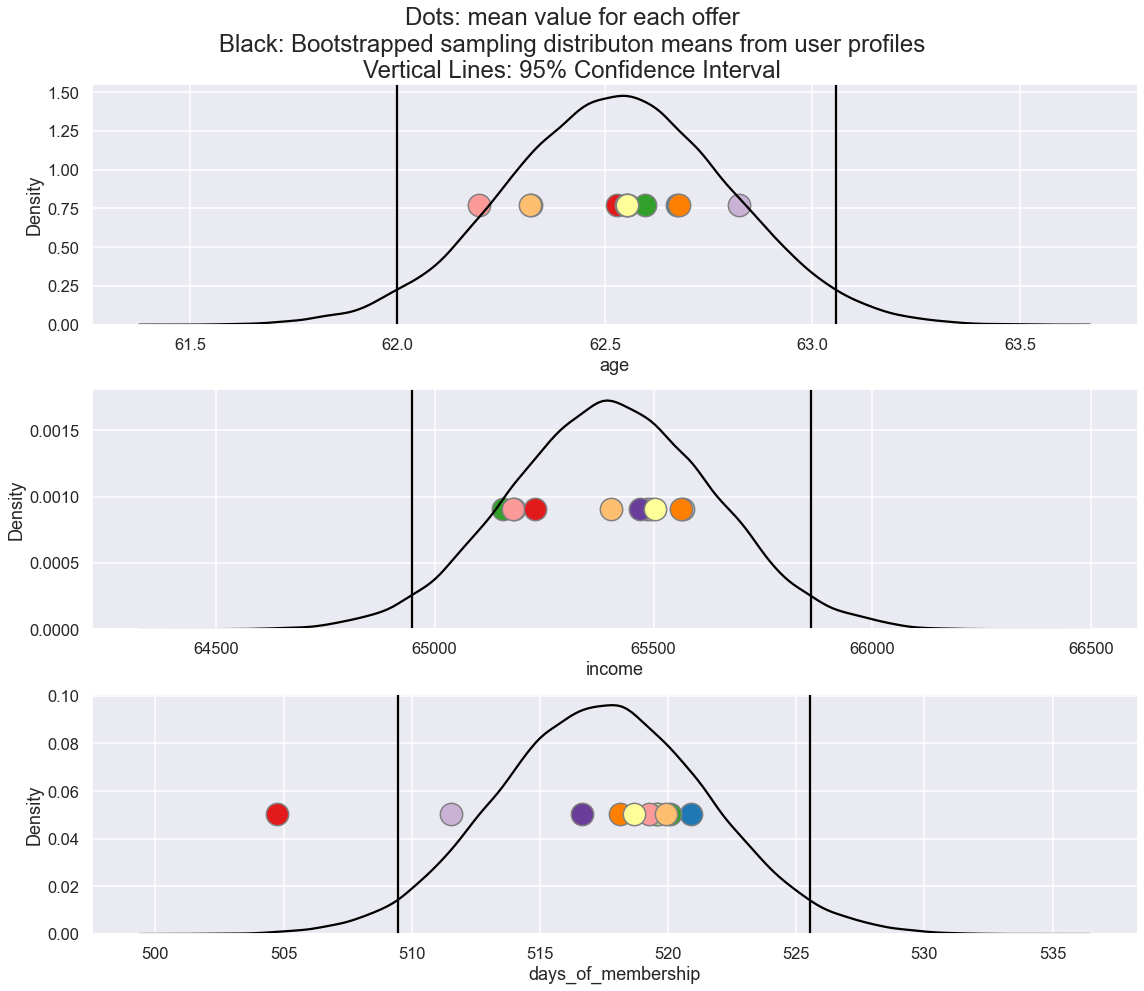

In [78]:
f, axs = plt.subplots(nrows=len(means.keys()), figsize=(16, 14))
axs = axs.flatten()
palette = sns.color_palette('Paired')

for i, key in enumerate(means.keys()):
    sns.kdeplot(data=means, x=key, ax=axs[i], color='black')
    axs[i].axvline(np.percentile(means[key], 2.5), color='black')
    axs[i].axvline(np.percentile(means[key], 97.5), color='black')
    for j, offer in enumerate(portfolio.id.unique()):
        axs[i].scatter(offers_df.loc[offers_df.offer_id==offer, key].mean(),
                       np.mean(axs[i].get_ylim()), color=palette[j], s=500, edgecolors='grey')
        
f.suptitle('Dots: mean value for each offer\n' + 
          'Black: Bootstrapped sampling distributon means from user profiles\n' +
          "Vertical Lines: 95% Confidence Interval", fontsize=24)
plt.tight_layout();

In [83]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [84]:
portfolio.id.unique()

array(['ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '3f207df678b143eea3cee63160fa8bed',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '5a8bc65990b245e5a138643cd4eb9837',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5', 'no_offer'], dtype=object)

# Invariant Metric Results

The 10-for-10 BOGO offer is statistically low in proportion of gender=Other and the buy-7-get-3 discount offer is statistically low on membership length.

In [69]:
# Shorten offer_id to make room on comparison plots
offers_rev['offer_id_short'] = offers_rev.offer_id.str.slice(0,8)

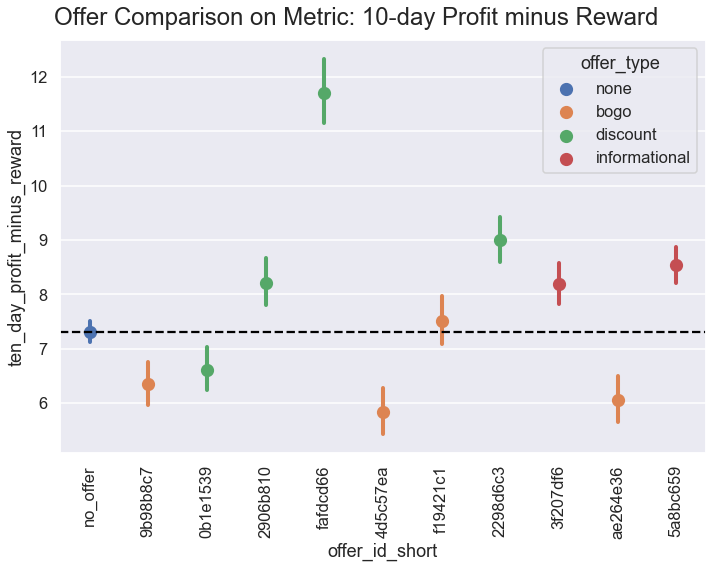

In [85]:
f, ax = plt.subplots(figsize=(10, 8))

sns.pointplot(data=offers_rev[offers_rev.time_received < 500], y='ten_day_profit_minus_reward', x='offer_id_short', hue='offer_type', join=False)
ax.tick_params(axis='x', rotation=90)
ax.axhline(offers_rev[(offers_rev.offer_id=='no_offer') &
                      (offers_rev.time_received < 500)]['ten_day_profit_minus_reward'].mean(),
           color='black', ls='--',)
f.suptitle('Offer Comparison on Metric: 10-day Profit minus Reward', fontsize=24)
plt.tight_layout();

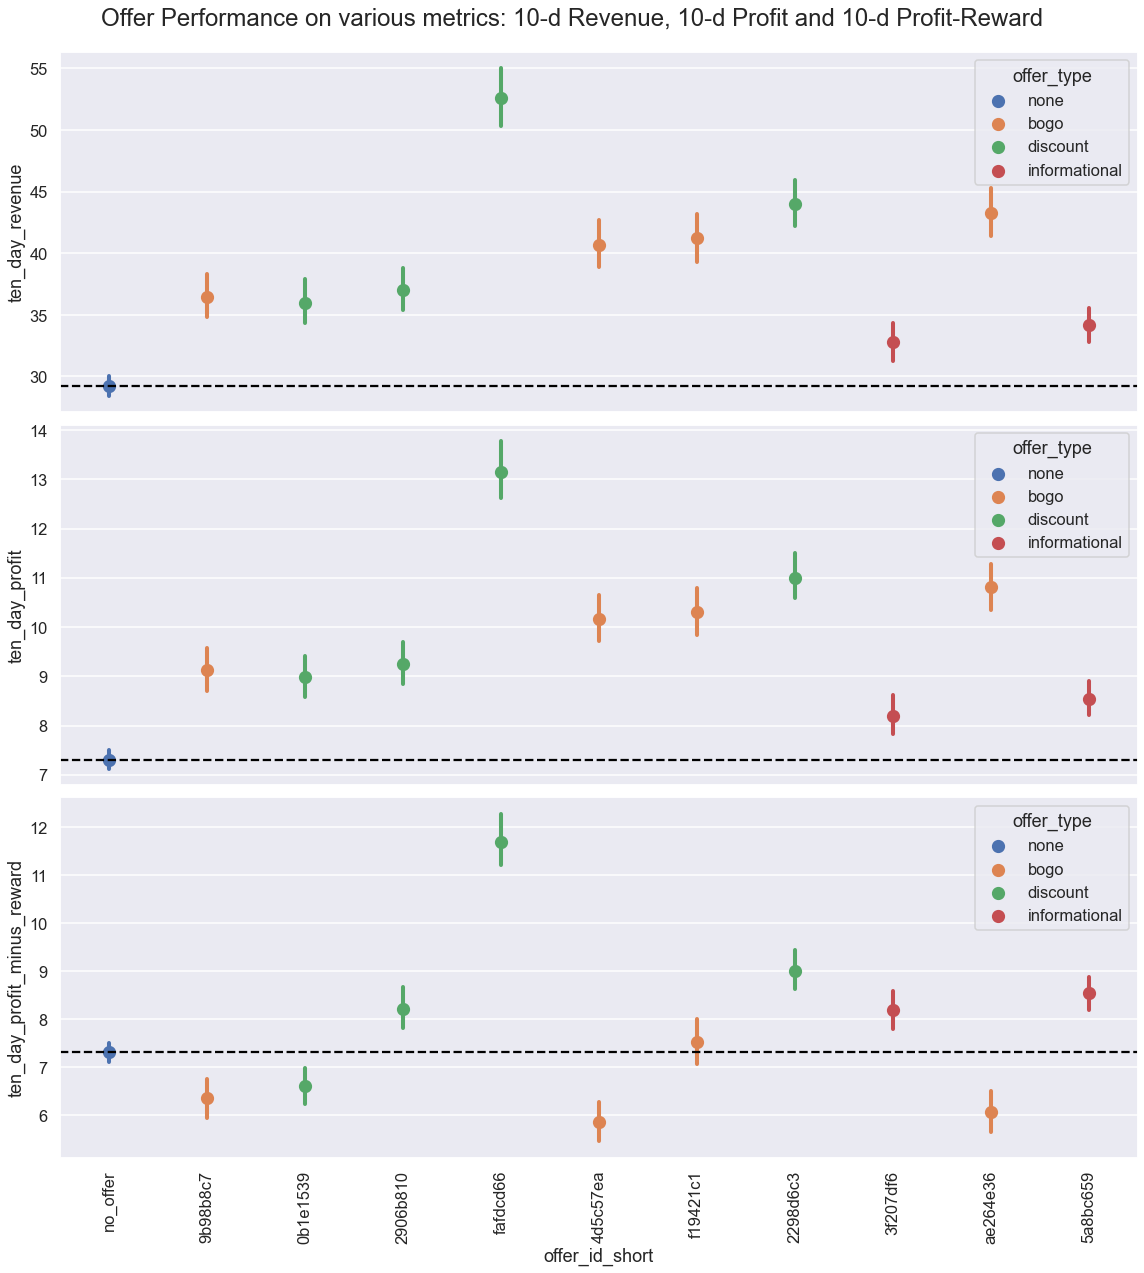

In [87]:
f, axs = plt.subplots(nrows=3, figsize=(16,18))
axs=axs.flatten()

for i, column in enumerate(['ten_day_revenue', 'ten_day_profit', 'ten_day_profit_minus_reward']):
    sns.pointplot(data=offers_rev[offers_rev.time_received < 500], y=column, x='offer_id_short', hue='offer_type',
                  join=False, ax=axs[i])
    axs[i].axhline(offers_rev[(offers_rev.offer_id=='no_offer') & 
                             (offers_rev.time_received < 500)][column].mean(), color='black', ls='--',)
    axs[i].tick_params(axis='x', rotation=90)

axs[0].set(xticks=[], xlabel='')
axs[1].set(xticks=[], xlabel='')
f.suptitle('Offer Performance on various metrics: 10-d Revenue, 10-d Profit and 10-d Profit-Reward\n', fontsize=24)
plt.tight_layout();

In [73]:
portfolio_extended[['id', 'offer_type', 'reward', 'difficulty', 'duration', 'frac_viewed']]

,id,offer_type,reward,difficulty,duration,frac_viewed
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,0.876991
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,0.961148
2,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,0.544046
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,0.543311
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,20,10,0.347287
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,7,7,0.959587
6,fafdcd668e3743c1bb461111dcafc2a4,discount,2,10,10,0.964460
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,0.877789
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,0.959451
9,2906b810c7d4411798c6938adc9daaa5,discount,2,10,7,0.539570


# Insights from Analysis as an A/B Test

## Invariant Metrics

The test generally appears adequate on the invariant metrics.  There are two offers which plot outside the confidence interval on the proportion of gender:Other and on the average account age.  With enough tests some statistically significant variations from the base distribution are to be expected.  These specific offers do not need to be excluded, but if analysis rates them significantly worse or better than the others these variations should be brought into play.


## Offer Performance

The best-performing offer in the data is the spend-10-get-2 discount offer, valid for 10 days.  This offer drove a lot of completions, generated a lot of 10d revenue and has a low cost in terms of reward.  The informational offers also do reasonably well, driving an increase in revenue with no required reward spend.

# Application of Machine Learning

So..  is that it?  The best offer is shown from the test.  The best strategy is to show everyone the 10-day spend-10-get-2 offer and call it a day.

Well, not so fast.  There are a couple of places where that strategy can be improved upon:

- There is no personalization of the offers.  The most loyal users spend a lot and tend to complete offers without viewing.  Is there wasted spend there?  Do certain users respond better to certain offer styles?  This test could be sliced to smaller and smaller intervals to develop heuristics and tests, but the small sample size will become a problem.
- The channel usage was uneven across the offers, and has a large impact on the results.  While the test does make clear that _particular combinations_ of channel usage and offer structure do worse than others, the test cannot tell us how that offer structure would have performed with broader channel usage.

## Plan: Use the data to go beyond the specific combinations used in the test

In [348]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf

In [114]:
# Define users "influenced" by an offer as users who:
# (a) Viewed an offer and (b) Did not complete it before viewing it
offers_rev['influenced'] = ((offers_rev[offers_rev.offer_id != 'no_offer'].viewed) & ~(
                            offers_rev[offers_rev.offer_id != 'no_offer'].time_completed <
                            offers_rev[offers_rev.offer_id != 'no_offer'].time_viewed))

In [162]:
offers_rev_subset = offers_rev[offers_rev.offer_id != 'no_offer'].loc[:,
    ['gender', 'age', 'days_of_membership', 'income', 'anonymous',
     'influenced', 'completed', 'ten_day_profit', 'offer_id']]
offers_rev_subset.head()

,gender,age,days_of_membership,income,anonymous,influenced,completed,ten_day_profit,offer_id
3,F,75,443,100000.0,False,True,True,21.7650,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,None,118,356,NaN,True,True,False,0.2725,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,M,68,91,70000.0,False,True,False,0.0000,2906b810c7d4411798c6938adc9daaa5
6,None,118,304,NaN,True,True,False,0.0000,fafdcd668e3743c1bb461111dcafc2a4
7,None,118,297,NaN,True,True,False,0.0000,4d5c57ea9a6940dd891ad53e9dbe8da0


In [332]:
def train_test_split(df, train_frac):
    """
    Splits the dataframe into training, validation and testing sets
    
    INPUT:
    df: (dataframe) - a pandas dataframe to be split
    train_frac: (float) - fraction of the dataset for training
    
    RETURNS:
    (train_df, test_df) - tuple of pandas dataframes
    """

    shuffled = df.sample(frac=1)
    train_end_index = round(df.shape[0] * train_frac)
    
    train_df = shuffled.iloc[0:train_end_index, :]
    test_df = shuffled.iloc[train_end_index:,:]
    
    return (train_df, test_df)

In [333]:
# split test dataset off at the beginning
# training data and validation data will be subsetted from the training data
# testing data will be subsetted from the testing data

train_df, test_df = train_test_split(offers_rev_subset, 0.8)

In [334]:
# fit scalers to the training data
scalers = {'days_of_membership': None, 'age': None, 'income': None}

for column in scalers.keys():
    scalers[column] = StandardScaler().fit(train_df[column].values.reshape(-1,1))

In [335]:
def prepare_tensorflow_dataset(df, scalers, categorical_variables, target):
    """
    A pipeline for preparing the offers dataframes for tensorflow.
    
    INPUT:
    df: (dataframe) - a dataframe with continuous variables to be scaled
    scalers: (dict) containing sklearn scaler objects, keys are column names
                    implicitly sets the list of continuous variables
    categorical_variables: (list): column names to pass to pd.get_dummies
    target: (str): the column containing the target values
    
    RETURNS:
    dataset: (tf.data.Dataset): a tensorflow dataset
    """
    
    # copy the dataframe in function scope and limit to relevant columns
    cols = list(scalers.keys()) + categorical_variables + [target]
    local_df = df[cols].copy()
    # scale the continuous variables
    for column in scalers.keys():
        local_df[column] = scalers[column].transform(local_df[column].values.reshape(-1,1))
        
    dummied = pd.get_dummies(local_df, columns=categorical_variables)
    X = dummied.loc[:,dummied.columns != target].values
    
    # tensorflow cannot accept boolean values so
    #   - if dtype is float, pass as is
    #   - else, convert to int
    if dummied.dtypes[target] == 'float64':
        y = dummied[target].values.reshape(-1,1)
    else:
        y = dummied[target].values.reshape(-1,1).astype(int)
        
    return tf.data.Dataset.from_tensor_slices((X, y))

# P(Influence) for users with a profile

In [336]:
# Get list of offers with all channels active
offers_all_channels = portfolio[portfolio.channel_web &
                                portfolio.channel_social &
                                portfolio.channel_mobile].id.tolist()

In [338]:
# prepare training and validation sets from train data
df_P_influence = train_df[train_df.offer_id.isin(offers_all_channels) & ~train_df.anonymous]
splits_p_influence = train_test_split(df_P_influence, 0.8)
train_infl, valid_infl = [prepare_tensorflow_dataset(data,
                                                     scalers,
                                                     ['gender'],
                                                     'influenced').batch(32) for data in splits_p_influence]

# prepare test data from test data
test_P_influence = test_df[test_df.offer_id.isin(offers_all_channels) & ~test_df.anonymous]
test_infl = prepare_tensorflow_dataset(test_P_influence,
                                      scalers,
                                      ['gender'],
                                      'influenced').batch(32)

In [339]:
# Callbacks

#Add Early Stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2)

#Add model checkpoint callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='influence_best.h5', 
                                                               monitor='val_loss', save_best_only=True,
                                                              save_freq='epoch', mode='auto')

In [374]:
# Clear session
tf.keras.backend.clear_session()

# Model Architecture
model_P_Influence = tf.keras.Sequential([tf.keras.layers.Dense(12, activation='relu'),
                                        tf.keras.layers.Dense(6, activation='relu'),
                                        tf.keras.layers.Dense(1)])

# Compile Model
model_P_Influence.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                          metrics=['accuracy'])

# Fit model
model_P_Influence.fit(train_infl, epochs=7, validation_data=valid_infl,
                     callbacks=[early_stop, model_checkpoint]);

# Load best model from training
model_P_Influence.load_weights('influence_best.h5')

Epoch 1/7
529/529 [==============================] - 1s 1ms/step - loss: 0.4690 - accuracy: 0.6877 - val_loss: 0.3708 - val_accuracy: 0.8775
Epoch 2/7
529/529 [==============================] - 0s 838us/step - loss: 0.3695 - accuracy: 0.8794 - val_loss: 0.3686 - val_accuracy: 0.8775
Epoch 3/7
529/529 [==============================] - 0s 812us/step - loss: 0.3678 - accuracy: 0.8794 - val_loss: 0.3681 - val_accuracy: 0.8775
Epoch 4/7
529/529 [==============================] - 0s 829us/step - loss: 0.3673 - accuracy: 0.8794 - val_loss: 0.3680 - val_accuracy: 0.8775


In [375]:
# make predictions of influence for the test dataset
labels = []
predictions = []
for features, batch_labels in test_infl:
    predictions.append(tf.math.sigmoid(model_P_Influence.predict(features).reshape(-1)))
    labels.append(batch_labels)

In [397]:
# tf.data.Dataset is an iterable, need to get a full list of predictions and labels from the test data
# define function to help

def predict_test_data(model, test_batches):
    """
    A function to return a pandas dataframe of predicted vs actual labels given a model and testing dataset.
    
    INPUT:
    model (tf.keras.model): the trained model
    test_batches (tf.data.Dataset): a batched dataset containing the testing data
    
    Returns:
    df (pd.DataFrame): a pandas dataframe containing predicted and actual values
    """
    
    labels = []
    predictions = []
    for features, batch_labels in test_batches:
        predictions.append(tf.math.sigmoid(model.predict(features).reshape(-1)))
        labels.append(batch_labels)
        
    df = pd.DataFrame(data={'labels': np.concatenate(labels).reshape(-1),
                  'predictions': np.concatenate(predictions)})
    
    return df

In [391]:
test_infl_result = predict_test_data(model_P_Influence, test_infl)

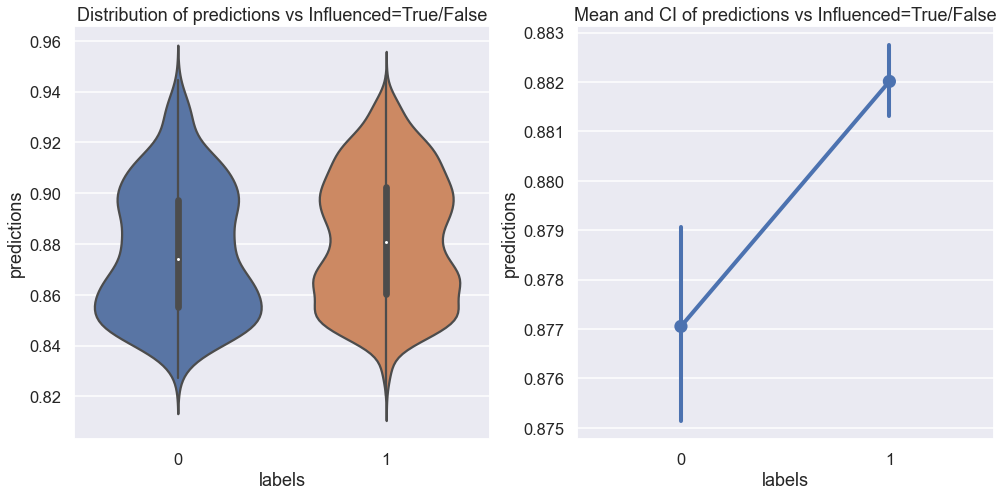

In [392]:
# plot results
f, axs = plt.subplots(ncols=2, figsize=(14,7))
axs = axs.flatten()
sns.violinplot(data=test_infl_result, x='labels', y='predictions', ax=axs[0])
sns.pointplot(data=test_infl_result, x='labels', y='predictions', ax=axs[1])
axs[0].set(title='Distribution of predictions vs Influenced=True/False')
axs[1].set(title='Mean and CI of predictions vs Influenced=True/False')
plt.tight_layout();

In [384]:
print("Average probability of influence (training data):", df_P_influence.influenced.mean())

Average probability of influence (training data): 0.8778802933522593


# Results: P(Influence) for users with a profile

The model for P(Influence) it not adding a lot of value.  There is very little separation in the predicted probabilities between cases where the user was in fact influenced or not influenced by the offer.

To avoid complexity where it doesn't add value we will use the constant probability of 0.88 from the training data.

# P(Influence) for anonymous users

In [385]:
# Anonymous users have only days_of_membership
# Remove remaining scalers in their case
scalers_anon = {'days_of_membership': scalers['days_of_membership']}

In [386]:
# prepare training and validation sets from train data
df_P_influence_anon = train_df[train_df.offer_id.isin(offers_all_channels) & train_df.anonymous]
splits_p_influence_anon = train_test_split(df_P_influence_anon, 0.8)
train_infl_anon, valid_infl_anon = [prepare_tensorflow_dataset(data,
                                                     scalers_anon,
                                                     [],
                                                     'influenced').batch(32) for data in splits_p_influence_anon]

# prepare test data from test data
test_P_influence_anon = test_df[test_df.offer_id.isin(offers_all_channels) & test_df.anonymous]
test_infl_anon = prepare_tensorflow_dataset(test_P_influence_anon,
                                      scalers_anon,
                                      [],
                                      'influenced').batch(32)

In [404]:
# Model checkpoint callback - different name
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='influence_best_anon.h5', 
                                                               monitor='val_loss', save_best_only=True,
                                                              save_freq='epoch', mode='auto')

# Model Architecture
model_P_Influence_anon = tf.keras.Sequential([tf.keras.layers.Dense(12, activation='relu'),
                                        tf.keras.layers.Dense(6, activation='relu'),
                                        tf.keras.layers.Dense(1)])

# Compile Model
model_P_Influence_anon.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                          metrics=['accuracy'])

# Fit model
model_P_Influence_anon.fit(train_infl_anon, epochs=7, validation_data=valid_infl_anon,
                     callbacks=[early_stop, model_checkpoint]);

# Load best model from training
model_P_Influence_anon.load_weights('influence_best_anon.h5')

Epoch 1/7
79/79 [==============================] - 1s 2ms/step - loss: 0.7300 - accuracy: 0.0523 - val_loss: 0.5381 - val_accuracy: 0.4320
Epoch 2/7
79/79 [==============================] - 0s 1ms/step - loss: 0.4827 - accuracy: 0.5939 - val_loss: 0.3400 - val_accuracy: 0.9552
Epoch 3/7
79/79 [==============================] - 0s 1ms/step - loss: 0.3084 - accuracy: 0.9543 - val_loss: 0.2398 - val_accuracy: 0.9552
Epoch 4/7
79/79 [==============================] - 0s 1ms/step - loss: 0.2319 - accuracy: 0.9543 - val_loss: 0.2029 - val_accuracy: 0.9552
Epoch 5/7
79/79 [==============================] - 0s 1ms/step - loss: 0.2063 - accuracy: 0.9543 - val_loss: 0.1914 - val_accuracy: 0.9552
Epoch 6/7
79/79 [==============================] - 0s 1ms/step - loss: 0.1989 - accuracy: 0.9543 - val_loss: 0.1879 - val_accuracy: 0.9552
Epoch 7/7
79/79 [==============================] - 0s 1ms/step - loss: 0.1967 - accuracy: 0.9543 - val_loss: 0.1867 - val_accuracy: 0.9552


In [405]:
test_infl_anon_result = predict_test_data(model_P_Influence_anon, test_infl_anon)

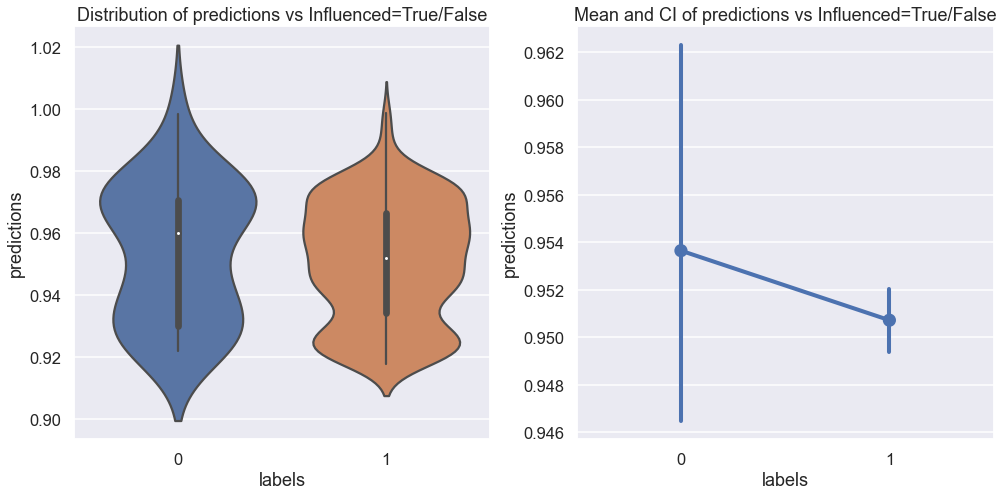

In [407]:
# plot results
f, axs = plt.subplots(ncols=2, figsize=(14,7))
axs = axs.flatten()
sns.violinplot(data=test_infl_anon_result, x='labels', y='predictions', ax=axs[0])
sns.pointplot(data=test_infl_anon_result, x='labels', y='predictions', ax=axs[1])
axs[0].set(title='Distribution of predictions vs Influenced=True/False')
axs[1].set(title='Mean and CI of predictions vs Influenced=True/False')
plt.tight_layout();

In [408]:
print("Average probability of influence (training data):", df_P_influence_anon.influenced.mean())

Average probability of influence (training data): 0.95744


# Modeling P(Influence) for anonymous users

The model for P(Influence) on anonymous users is also poor.  In this case again a constant probability of influence will be used. (96%)

In [ ]:
# preprocess data for the Revenue predictor network for influenced offers
# limit to influenced offers and users with profile

# scale continuous features
# one-hot encode categorical features

In [ ]:
# preprocess data for the Revenue predictor network for no_offer
# limit to offer = no_offer and users with profile

# scale continuous features
# one-hot encode categorical features

In [ ]:
# repeat for anonymous users network for P(Influence), P(Complete | Influence), P(Complete | !Influence)
# limit to anonymous users

# scale the single feature (days_of_membership)

In [ ]:
# preprocess data for Revenue predictor network for influenced offers, anonymous users
# limit to influenced offers and anonymous users

# scale continuous feature
# one-hot encode offer_id

In [ ]:
# preprocess data for the Revenue predictor network for no_offer
# limit to offer = no_offer and anonymous users

# scale continuous features
# one-hot encode categorical features